In [27]:
import importlib
import matplotlib.pyplot as plt
import numpy
import os
cvx_path = os.path.abspath(os.path.join('..', '..', 'cvxEDA', 'src'))
module_path = os.path.abspath(os.path.join('..', '..', 'src'))
import sys
sys.path.append(module_path)

import tools.data_reader_apd as dr_a
import tools.data_reader_case as dr_c
import tools.data_reader_wesad as dr_w

import tools.display_tools as dt
import tools.preprocessing as preprocessing

import train

In [28]:
importlib.reload(dt)
importlib.reload(train)
importlib.reload(preprocessing)
importlib.reload(dr_a)
importlib.reload(dr_c)
importlib.reload(dr_w)

anxiety_label_type = None
case_label_type = dr_c.SelfReports.AROUSAL
wesad_label_type = "stai"

threshold = "fixed"

metrics = [
    train.Metrics.BPM, 
    train.Metrics.RMSSD, 
    train.Metrics.HF_RR, 
    train.Metrics.LF_RR, 
    train.Metrics.SDNN, 
    train.Metrics.MEAN_SCL, 
    train.Metrics.SCR_RATE
# ]
] + train.Metrics.STATISTICAL

model_phases_apd = [
    "Baseline_Rest", 
    "BugBox_Relax", "BugBox_Anticipate", "BugBox_Exposure", "BugBox_Break",
    "Speech_Relax", "Speech_Anticipate", "Speech_Exposure", "Speech_Break"
]
model_phases_wesad = dr_w.Phases.PHASE_ORDER


temp_a, _ = train.Train_APD.get_apd_data_ranking([train.Metrics.BPM], phases=dr_a.Phases.PHASES_LIST, normalize=False)
idx = temp_a[temp_a["bpm"] > 200].index 
invalid_apd_subjects = set(temp_a["subject"].iloc[idx].tolist())
idx = temp_a[temp_a["bpm"] < 35].index 
invalid_apd_subjects.update(set(temp_a["subject"].iloc[idx].tolist()))

temp_a, _ = train.Train_CASE.get_case_data(metrics, verbose=False, label_type=case_label_type, threshold=threshold, normalize=False)
idx = temp_a[temp_a["bpm"] > 200].index 
invalid_case_subjects = set(temp_a["subject"].iloc[idx].tolist())
idx = temp_a[temp_a["bpm"] < 35].index 
invalid_case_subjects.update(set(temp_a["subject"].iloc[idx].tolist()))

temp_a, _ = train.Train_WESAD.get_wesad_data([train.Metrics.BPM], phases=dr_w.Phases.PHASE_ORDER, normalize=False)
idx = temp_a[temp_a["bpm"] > 200].index 
invalid_wesad_subjects = set(temp_a["subject"].iloc[idx].tolist())
idx = temp_a[temp_a["bpm"] < 35].index 
invalid_wesad_subjects.update(set(temp_a["subject"].iloc[idx].tolist()))

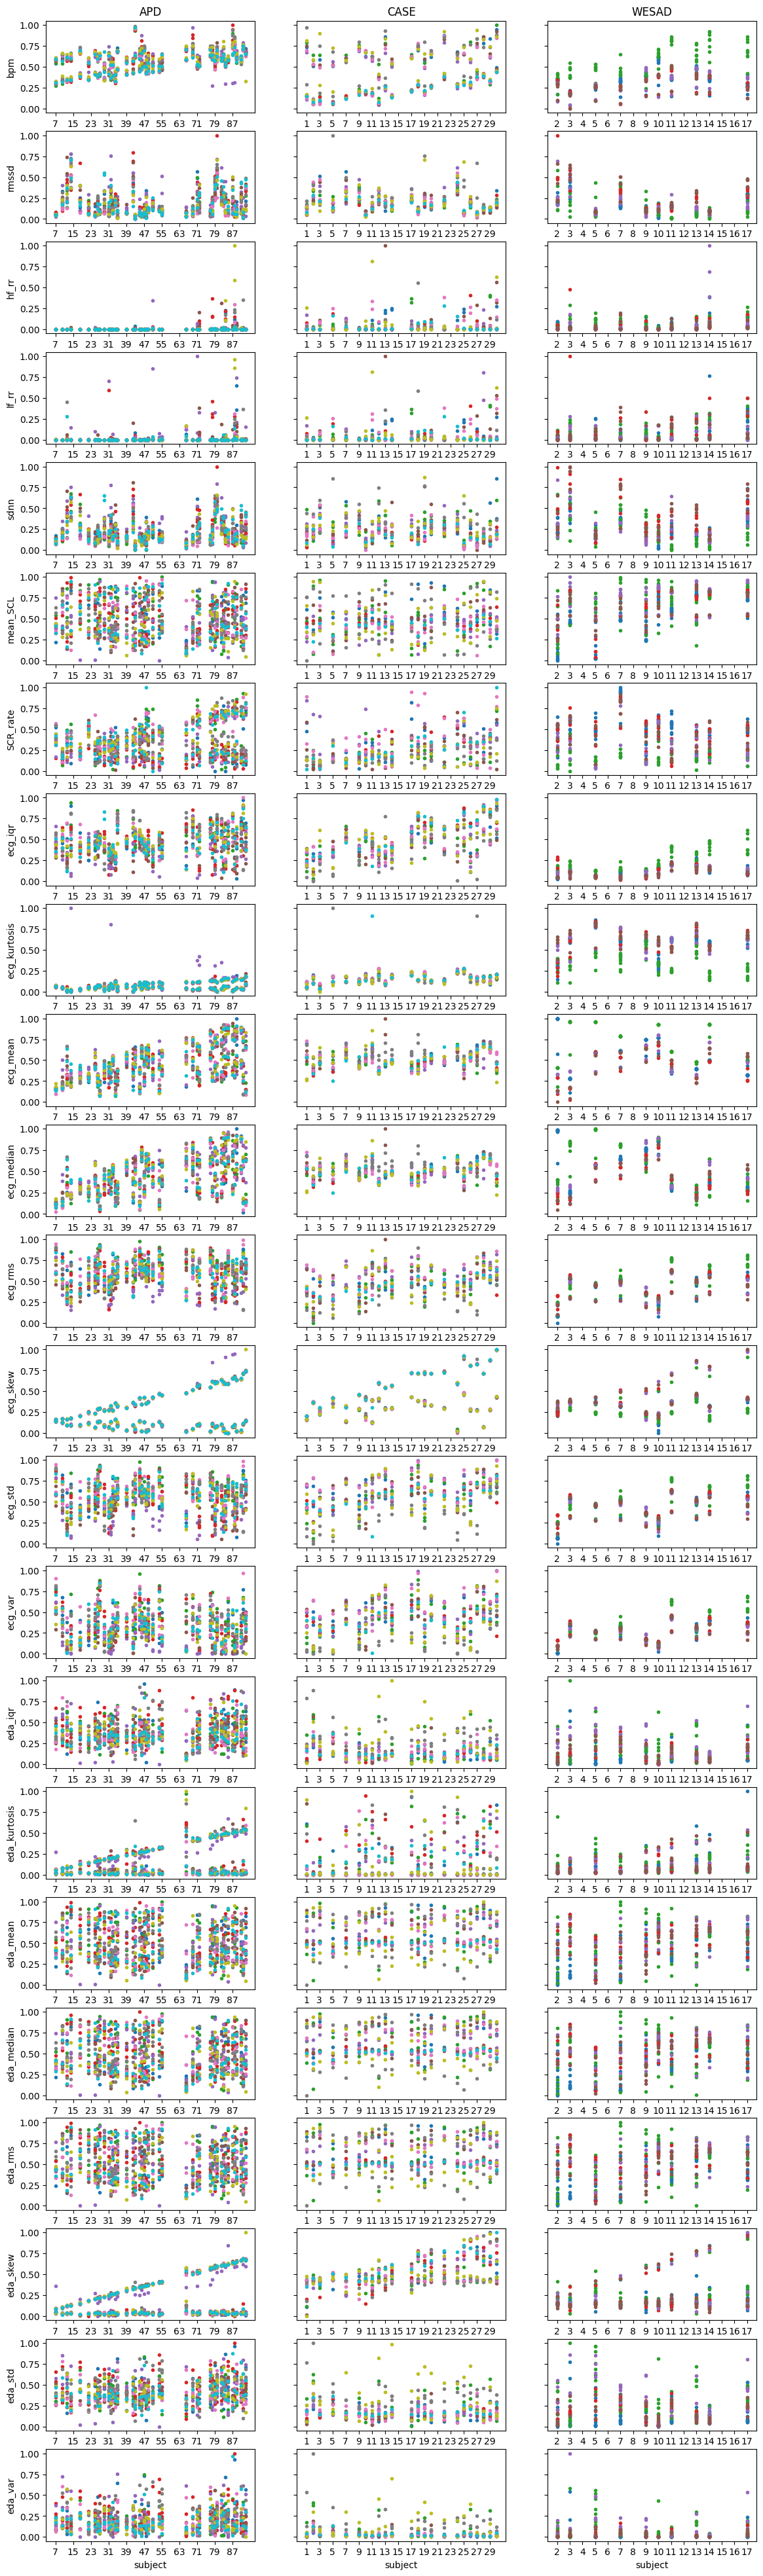

In [29]:
# FEATURE SCATTERPLOTS
importlib.reload(dt)
importlib.reload(train)
importlib.reload(preprocessing)
importlib.reload(dr_a)
importlib.reload(dr_c)
importlib.reload(dr_w)

import matplotlib
import numpy as np


colors = [
    "tab:blue", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan"
]

metrics = [
    train.Metrics.BPM, 
    train.Metrics.RMSSD, 
    train.Metrics.HF_RR, 
    train.Metrics.LF_RR, 
    train.Metrics.SDNN, 
    train.Metrics.MEAN_SCL, 
    train.Metrics.SCR_RATE,
    train.Metrics.ECG_IQR, 
    train.Metrics.ECG_KURTOSIS, 
    train.Metrics.ECG_MEAN,
    train.Metrics.ECG_MEDIAN, 
    train.Metrics.ECG_RMS, 
    train.Metrics.ECG_SKEW, 
    train.Metrics.ECG_STD, 
    train.Metrics.ECG_VAR,
    train.Metrics.EDA_IQR,
    train.Metrics.EDA_KURTOSIS, 
    train.Metrics.EDA_MEAN, 
    train.Metrics.EDA_MEDIAN, 
    train.Metrics.EDA_RMS, 
    train.Metrics.EDA_SKEW, 
    train.Metrics.EDA_STD, 
    train.Metrics.EDA_VAR
]

x_a, y_a = train.Train_APD.get_apd_data_ranking(metrics, model_phases_apd, verbose=False, anxiety_label_type=anxiety_label_type, threshold=threshold, normalize=True)
x_c, y_c = train.Train_CASE.get_case_data(metrics, verbose=False, label_type=case_label_type, threshold=threshold, normalize=True)
x_w, y_w = train.Train_WESAD.get_wesad_data(metrics, model_phases_wesad, verbose=False, label_type=wesad_label_type, threshold=threshold, normalize=True)

x_a = x_a[~x_a["subject"].isin(invalid_apd_subjects)].reset_index(drop=True)
y_a = y_a[~y_a["subject"].isin(invalid_apd_subjects)].reset_index(drop=True)
x_c = x_c[~x_c["subject"].isin(invalid_apd_subjects)].reset_index(drop=True)
y_c = y_c[~y_c["subject"].isin(invalid_apd_subjects)].reset_index(drop=True)
x_w = x_w[~x_w["subject"].isin(invalid_apd_subjects)].reset_index(drop=True)
y_w = y_w[~y_w["subject"].isin(invalid_apd_subjects)].reset_index(drop=True)

data = [x_a, x_c, x_w]
# data = [x_c]

matplotlib.rcParams.update({'font.size': 10})
matplotlib.rcParams.update({'lines.markersize': 3})
fig, axs = plt.subplots(len(metrics), len(data), sharey="row", figsize=(14, 50))

axs[0][0].set_title("APD")
axs[0][1].set_title("CASE")
axs[0][2].set_title("WESAD")
# axs[0].set_title("CASE")

for i in range(len(metrics)):
    axs[i][0].set_ylabel(metrics[i])
    # axs[i].set_ylabel(metrics[i])

for i in range(len(data)):
    axs[len(metrics)-1][i].set_xlabel("subject")
    # axs[len(metrics)-1].set_xlabel("subject")

for row, metric in enumerate(metrics):
    for col in range(len(data)):
        phases = list(np.unique(data[col].loc[:, "phaseId"]))
        dataset = data[col]
        # axs[row][col].scatter(data[col].loc[:, "subject"], data[col].loc[:, metric])
        for phase in phases:
            temp = dataset[dataset["phaseId"] == phase]
            x = temp.loc[:, "subject"]
            y = temp.loc[:, metric]
            axs[row][col].scatter(x, y, color=colors[phase], label=phase)
            # axs[row].scatter(temp.loc[:, "subject"], temp.loc[:, metric], color=colors[phase])
            axs[row][col].set_xticks(np.arange(min(x), max(x)+1, (max(x) - min(x)) // 10))
            # axs[row][col].legend()

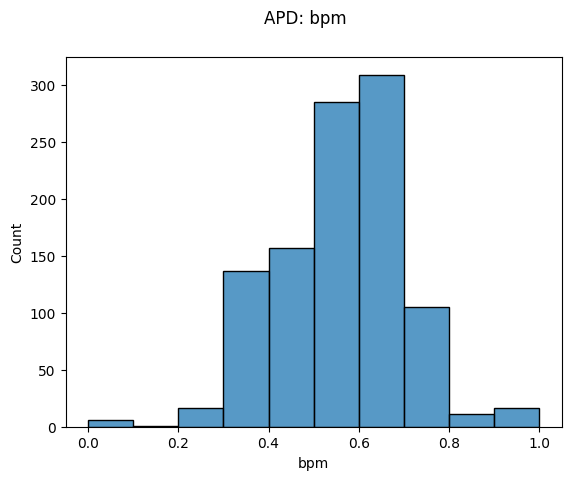

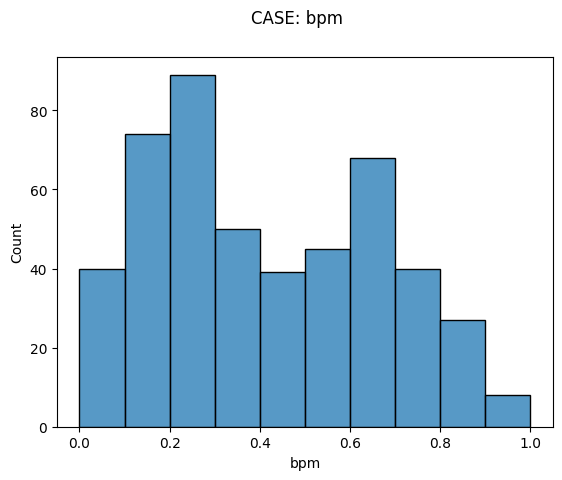

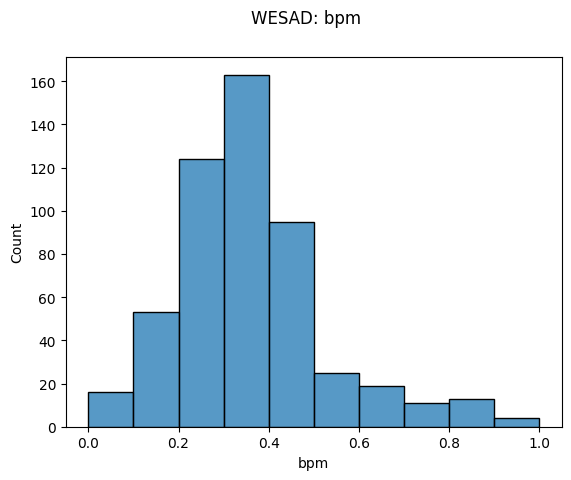

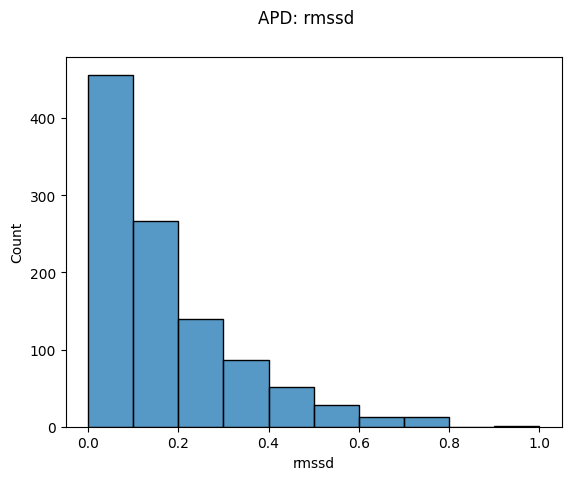

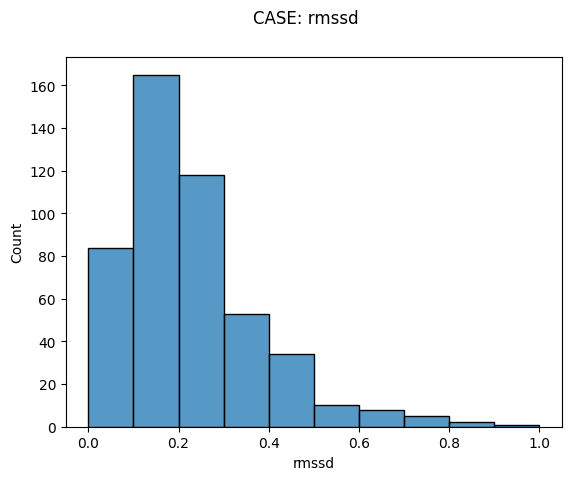

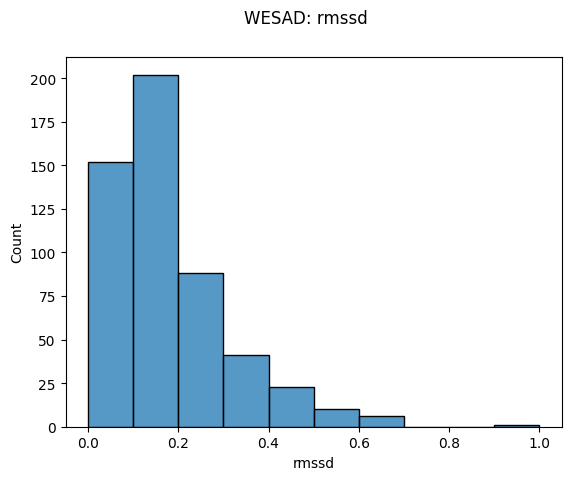

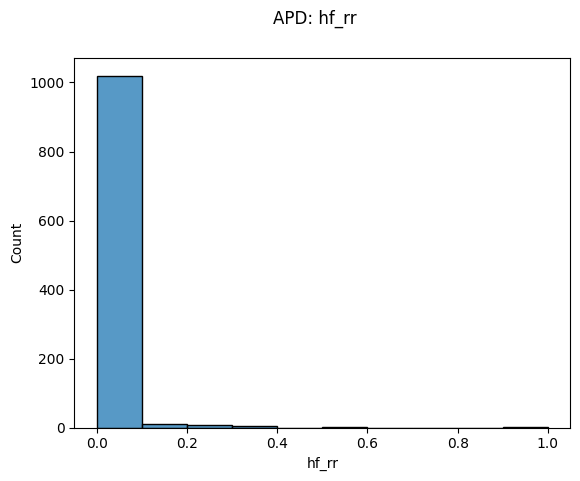

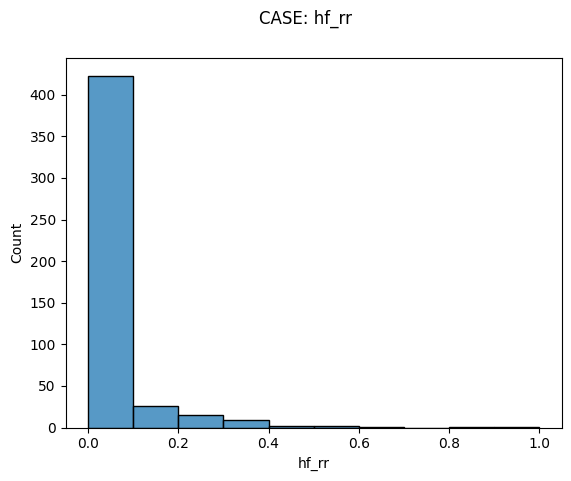

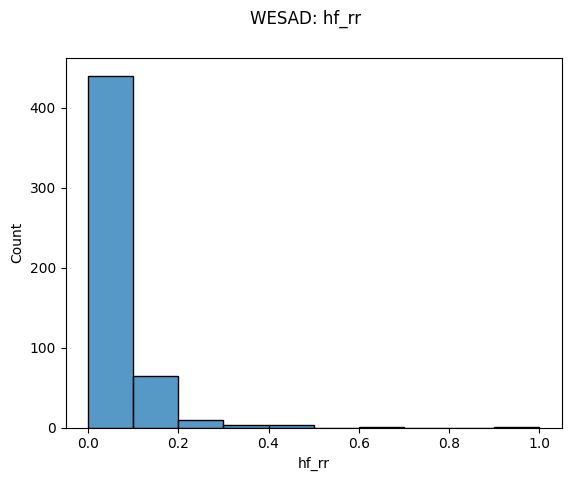

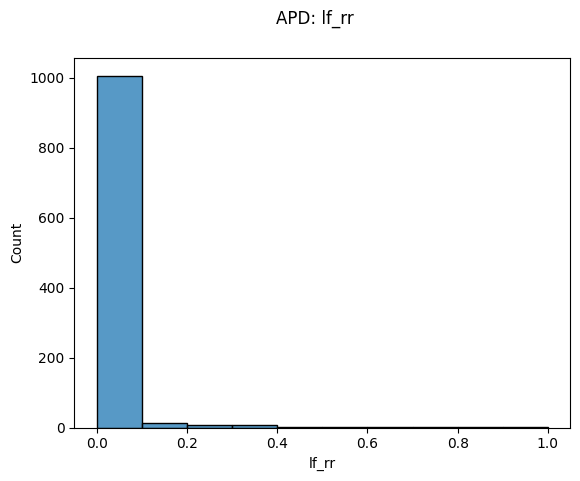

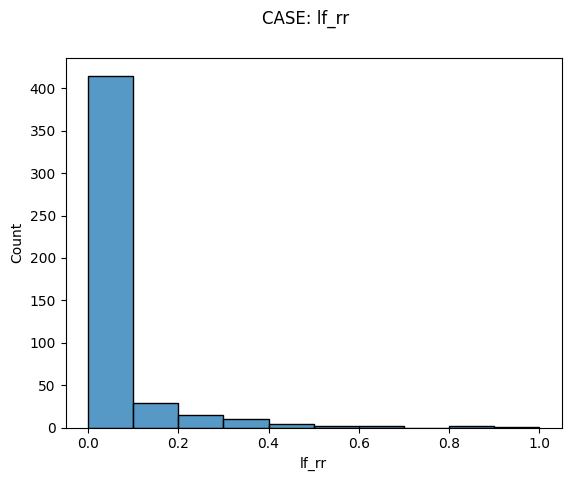

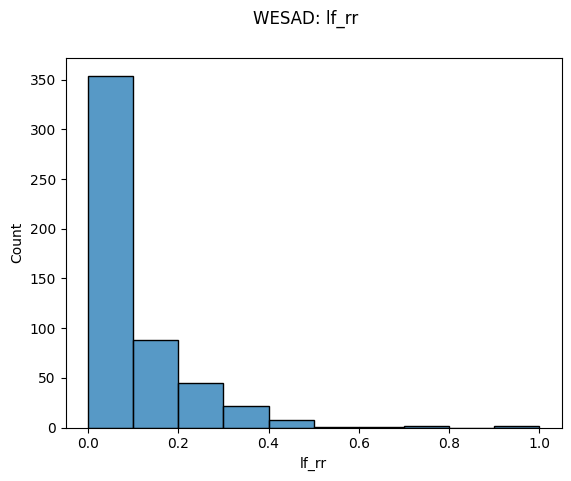

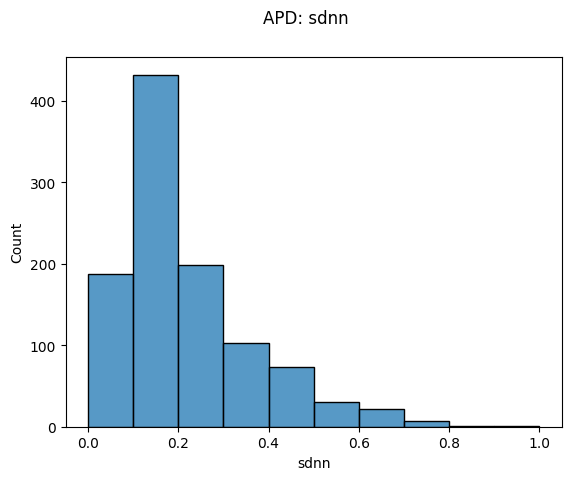

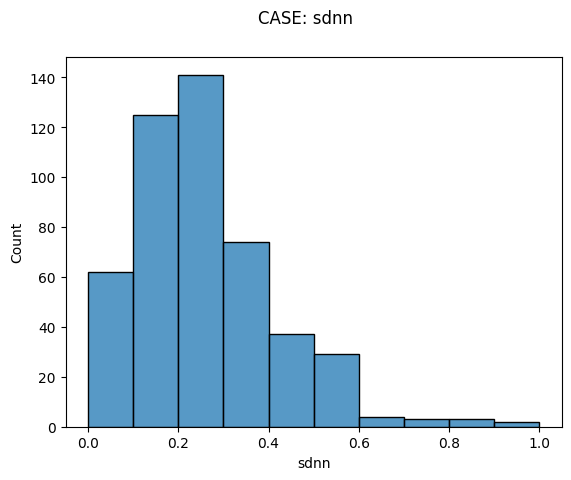

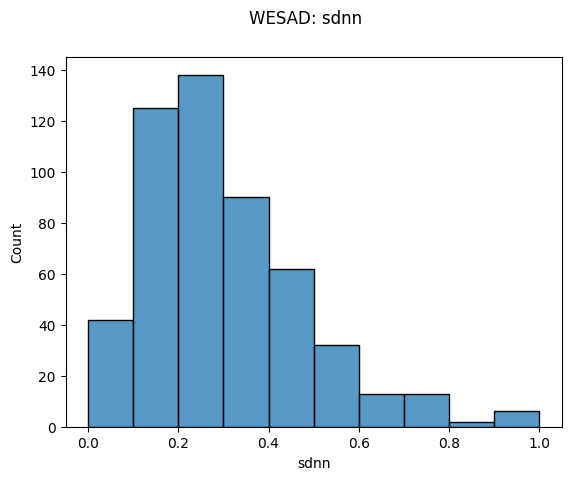

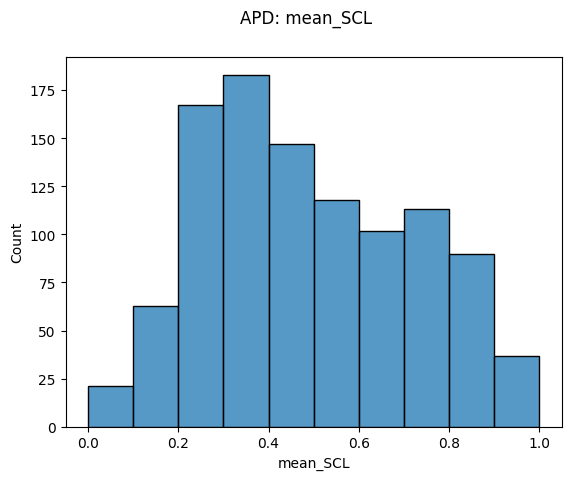

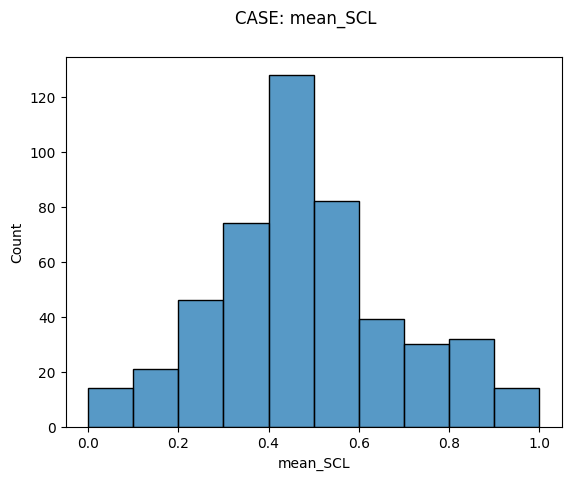

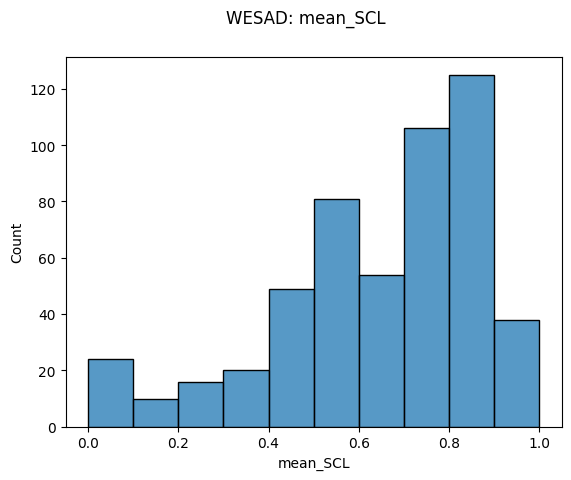

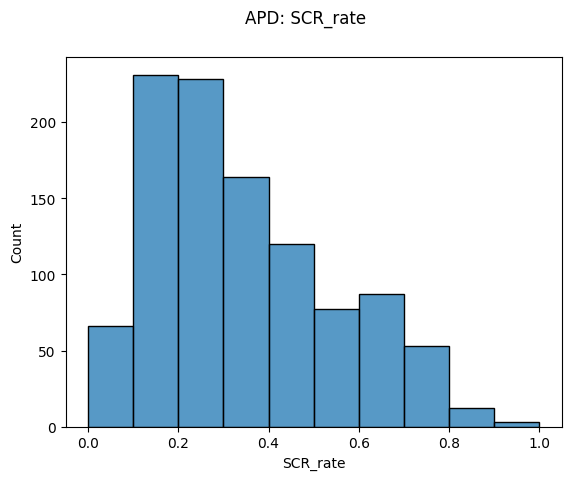

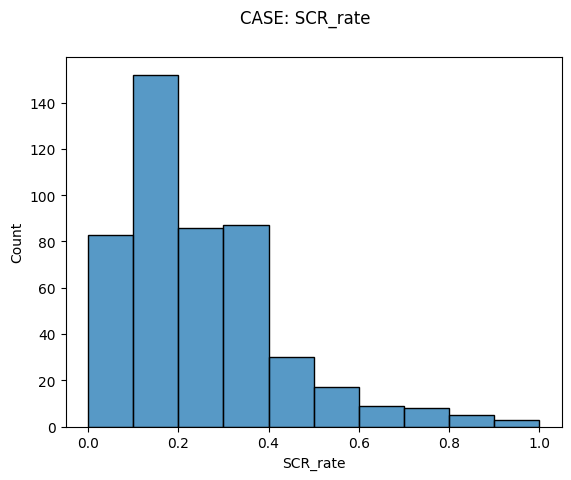

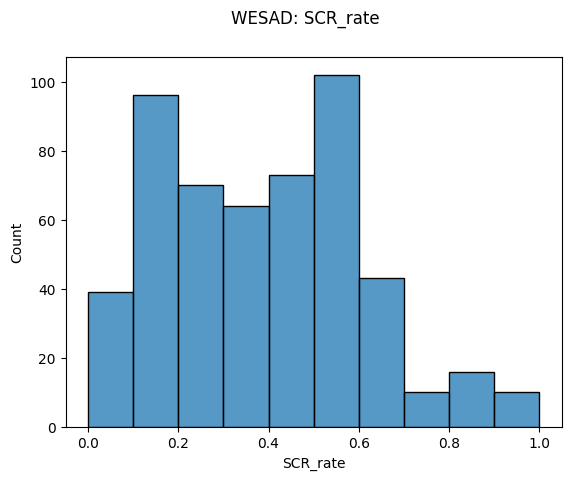

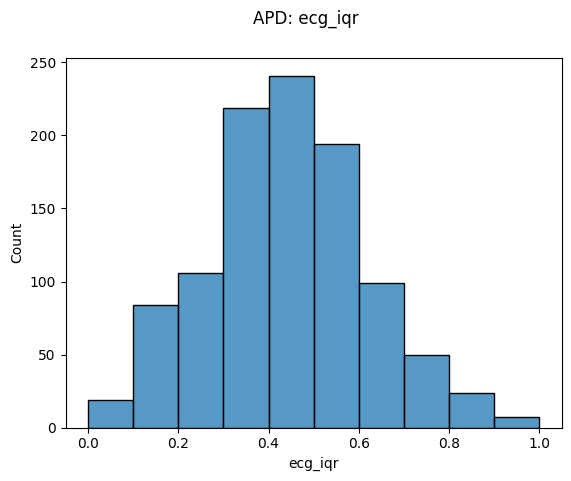

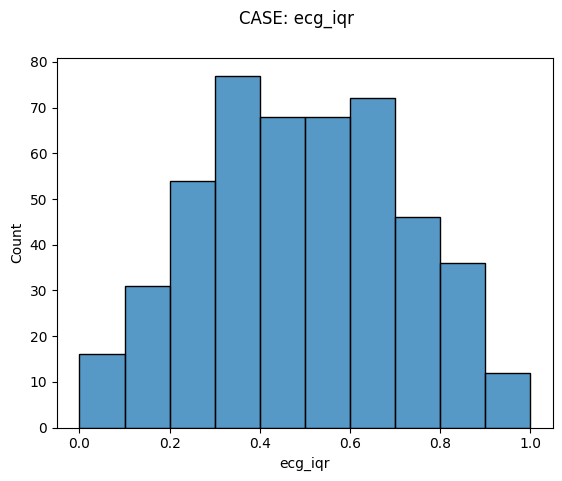

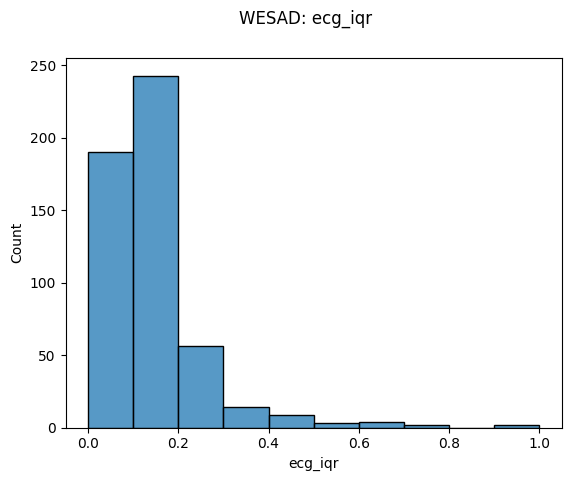

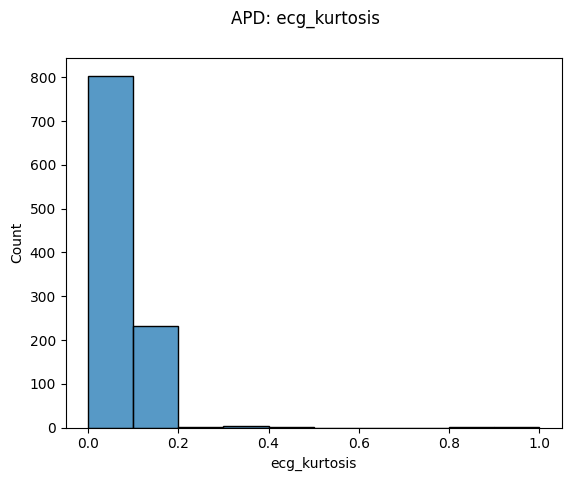

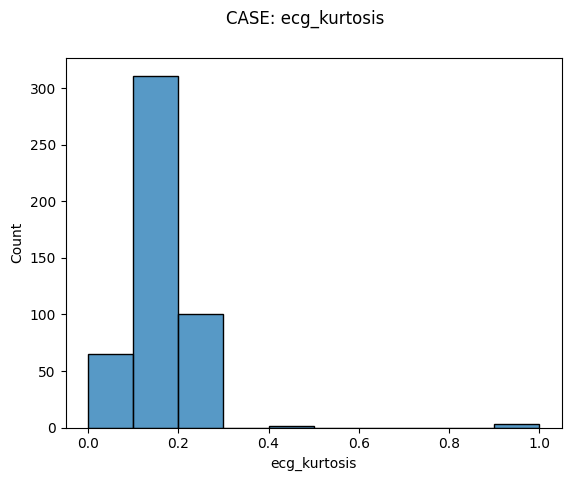

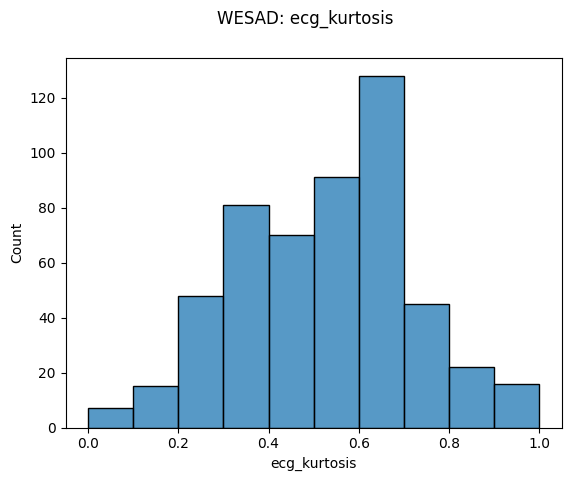

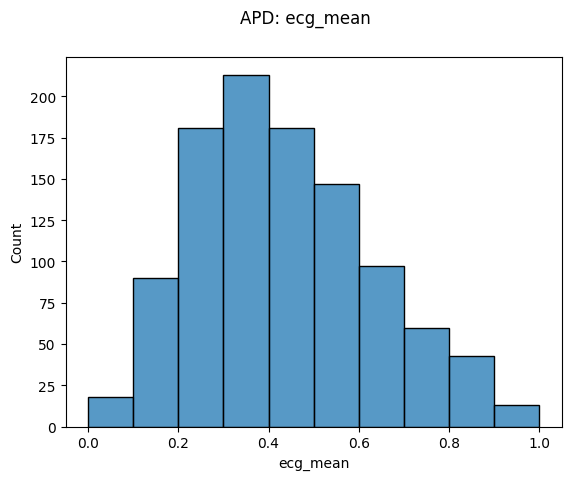

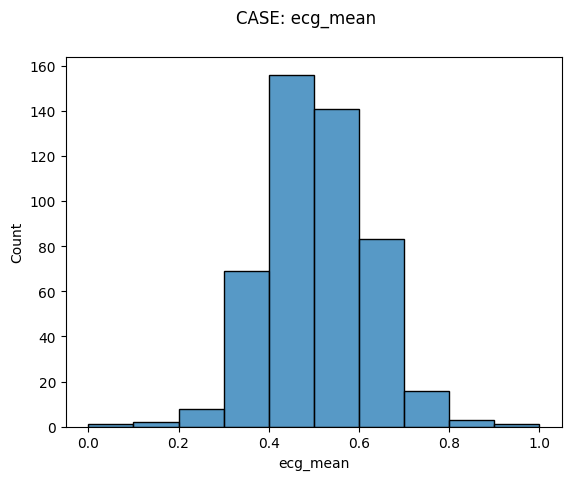

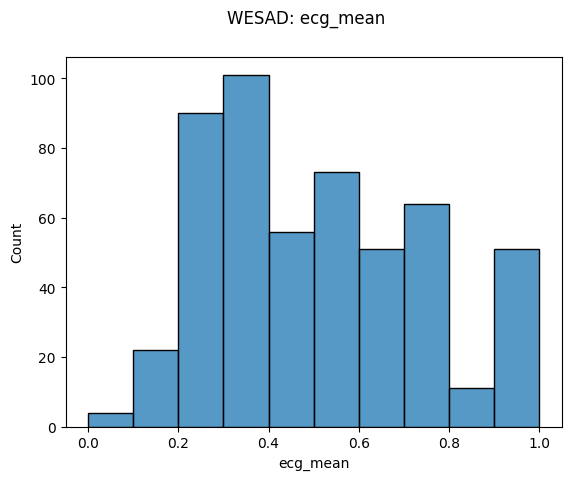

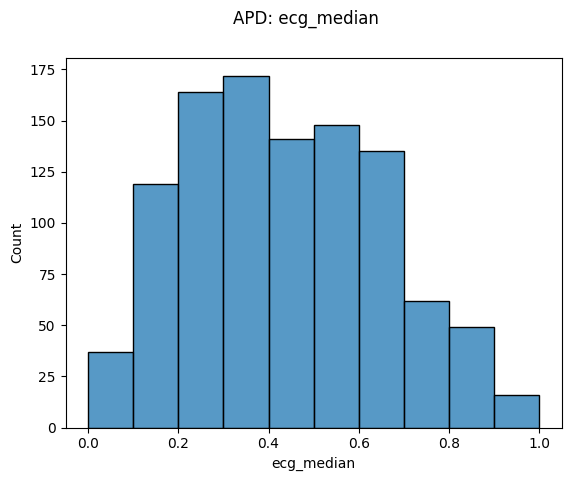

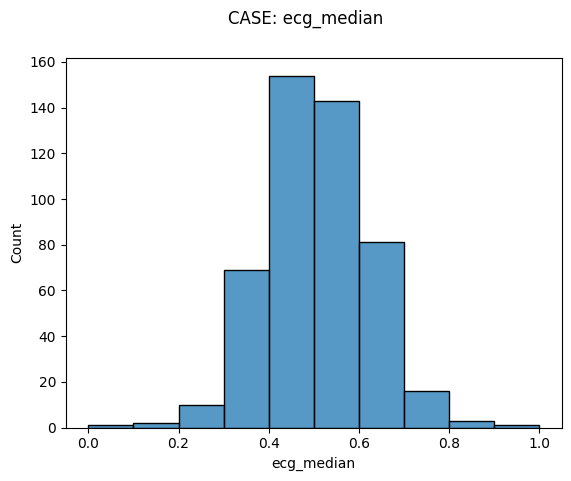

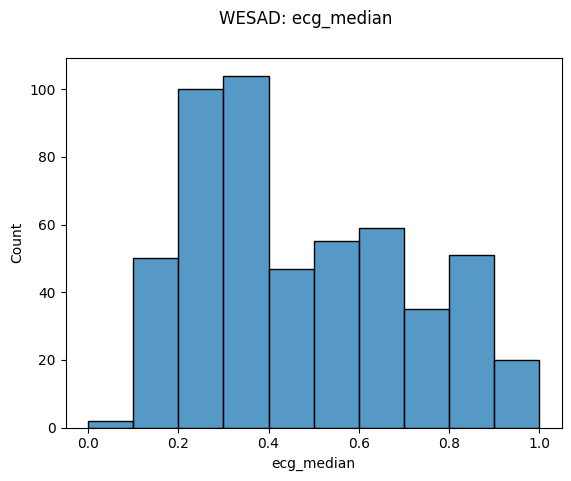

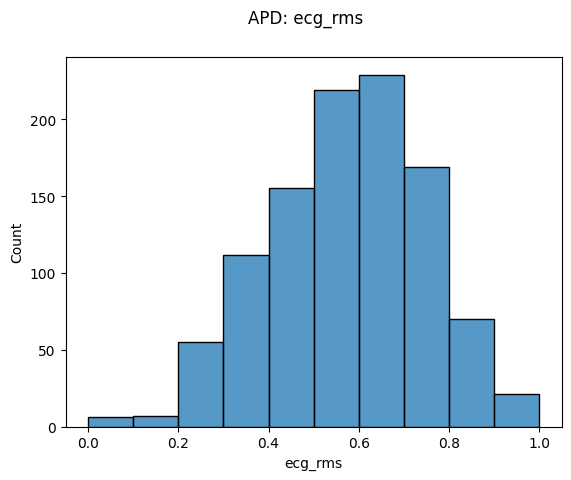

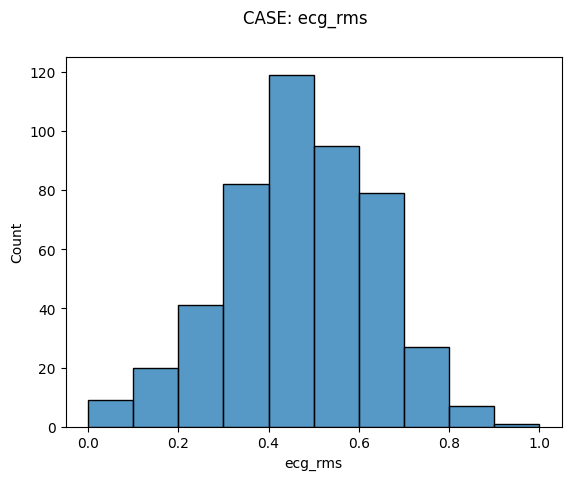

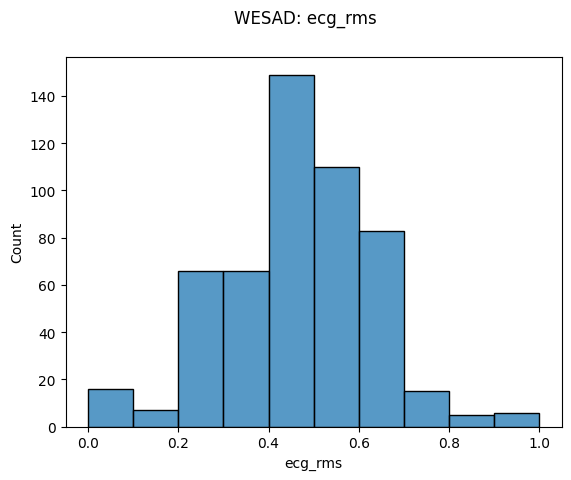

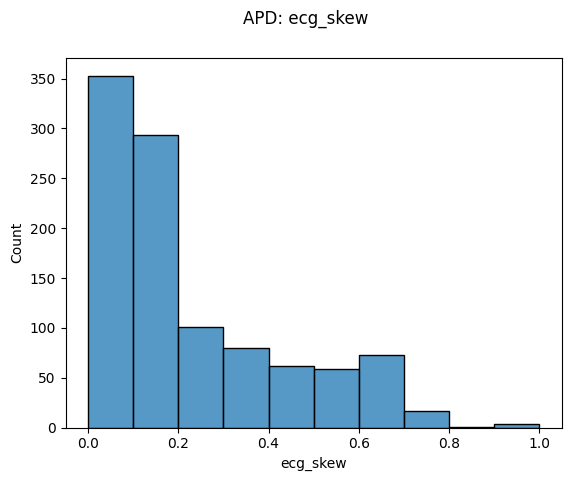

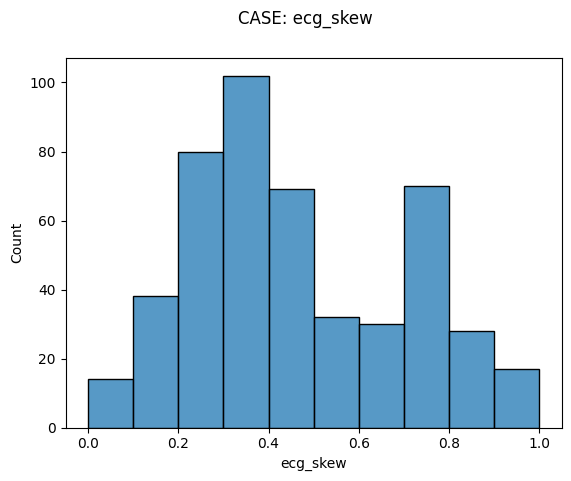

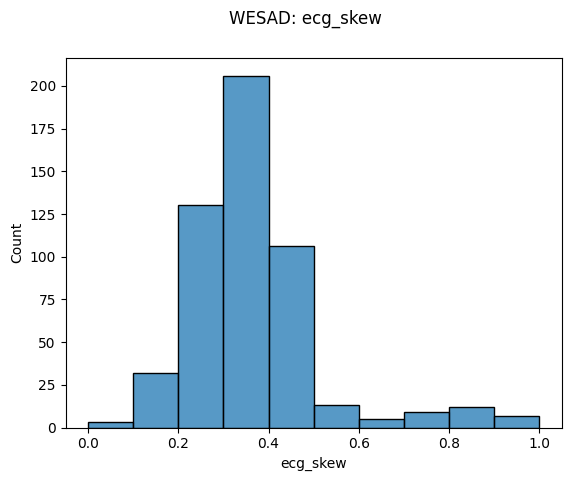

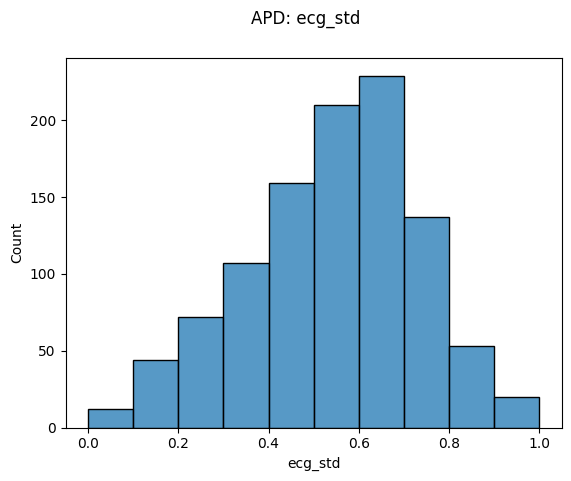

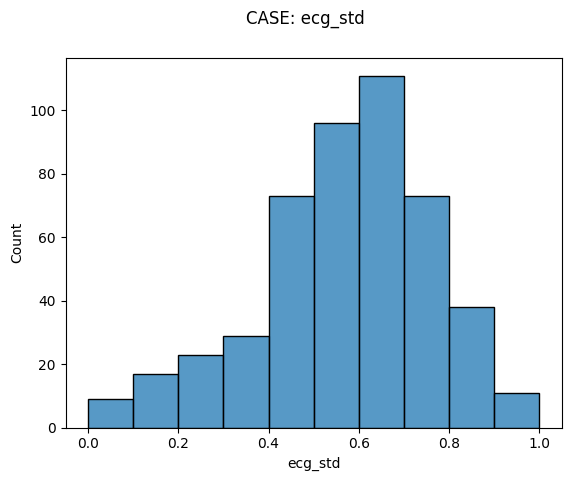

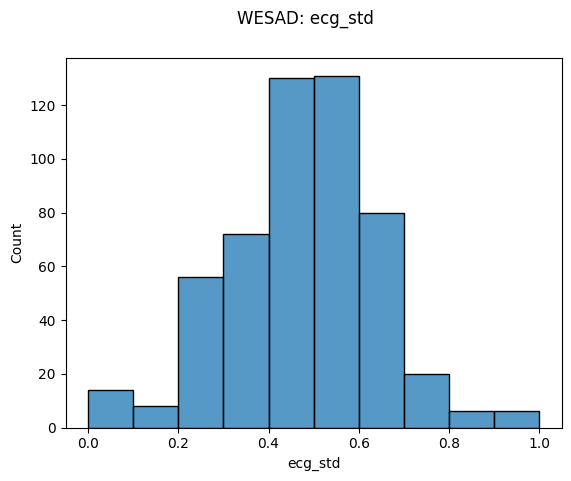

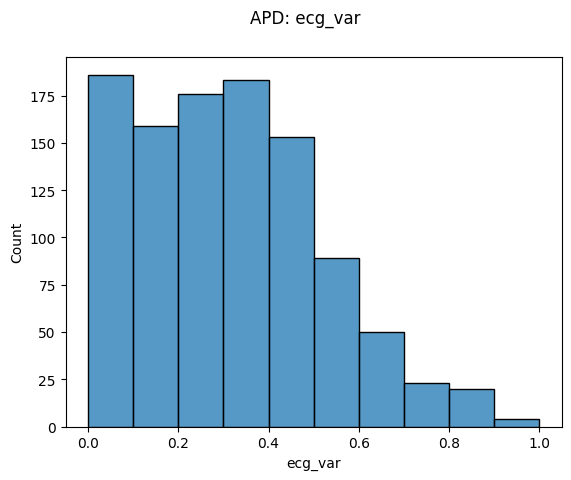

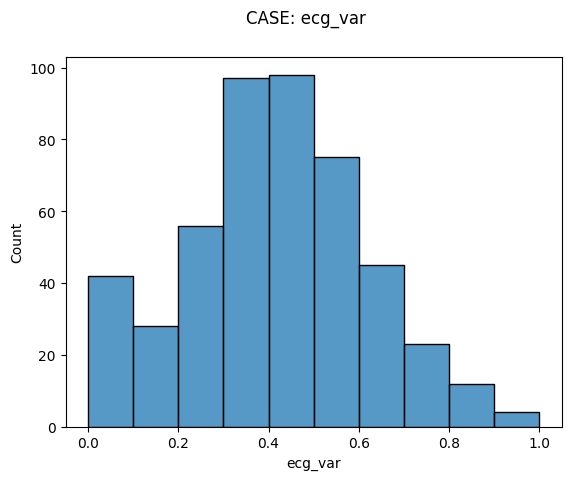

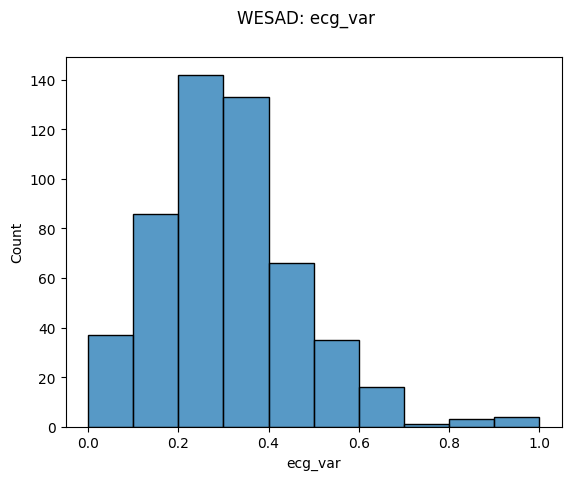

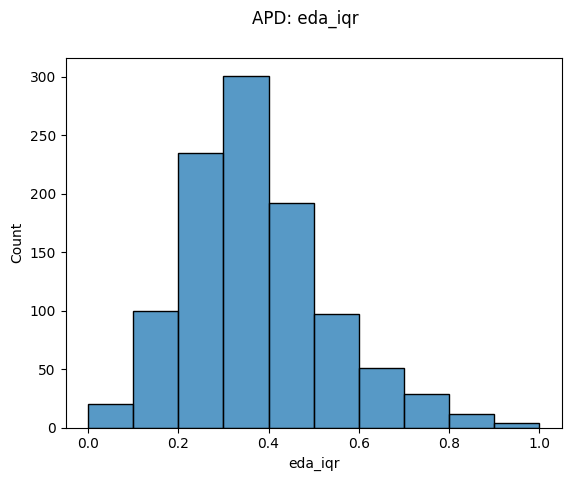

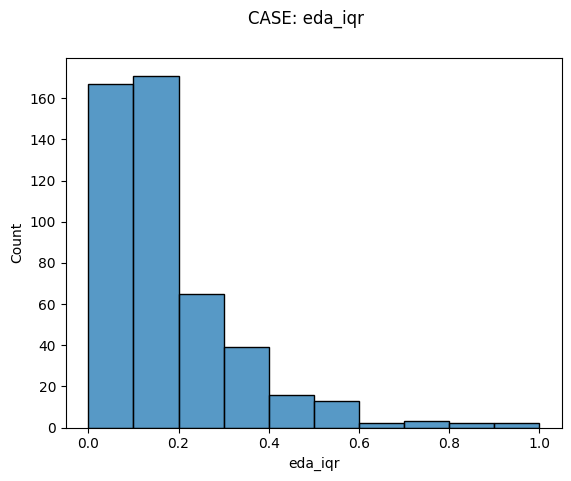

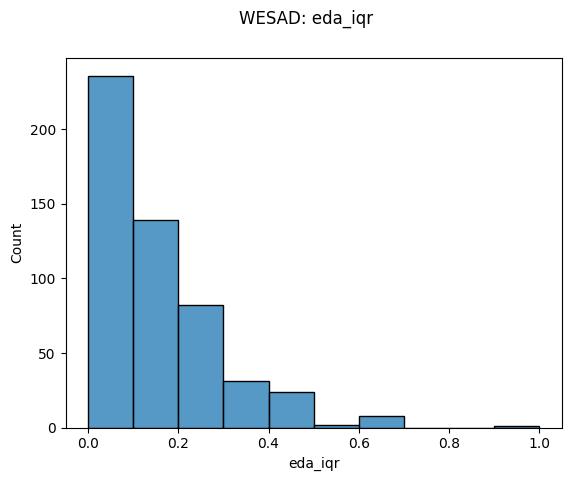

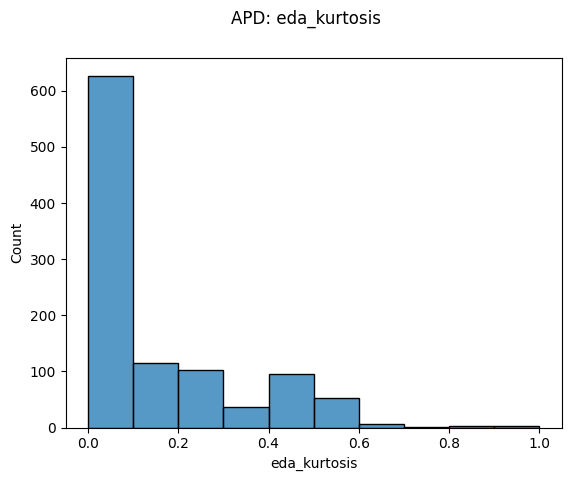

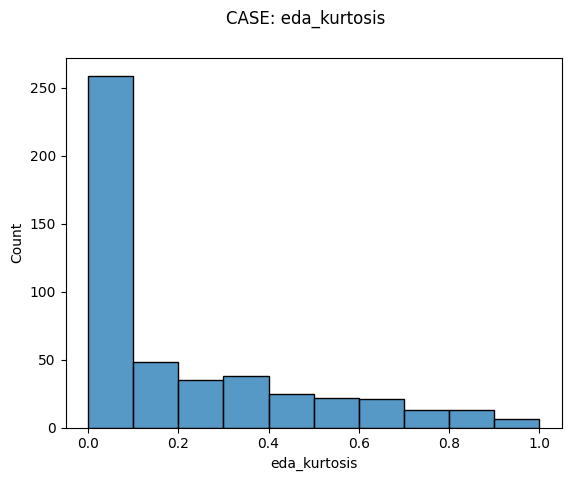

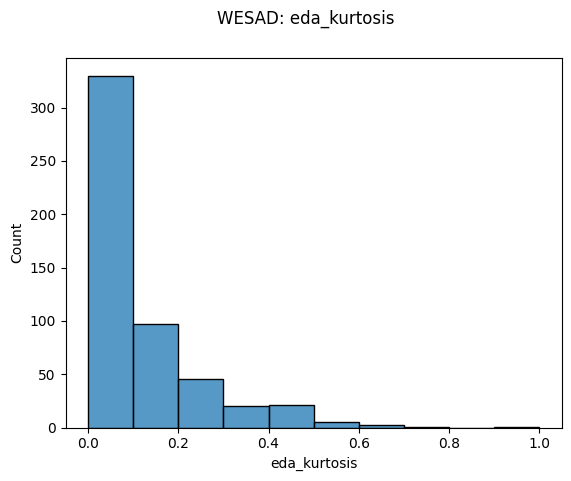

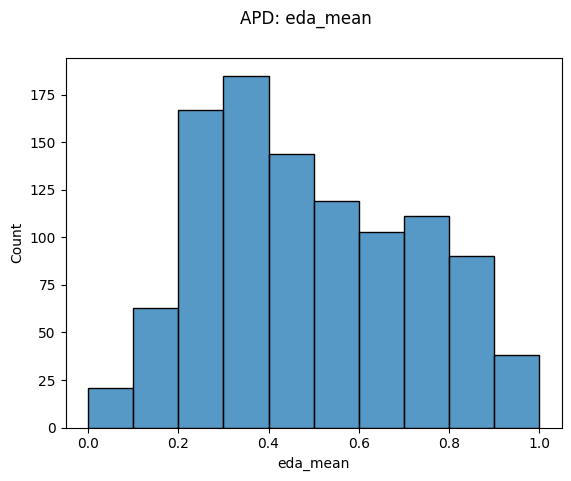

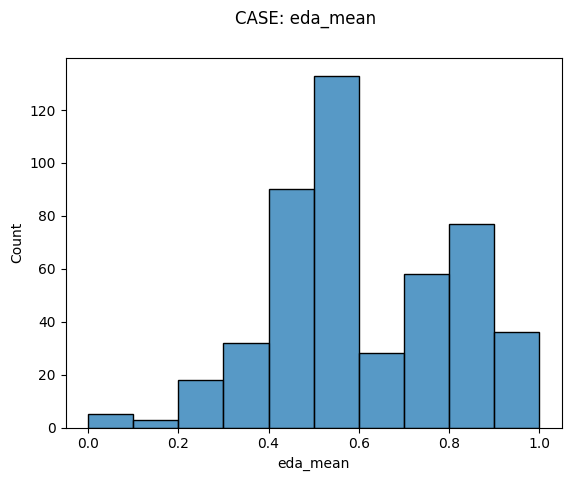

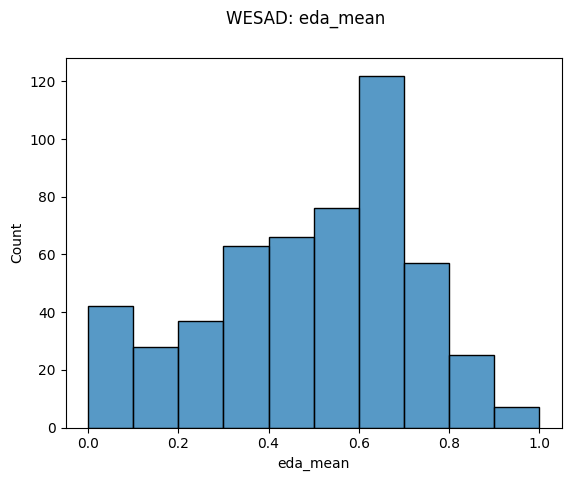

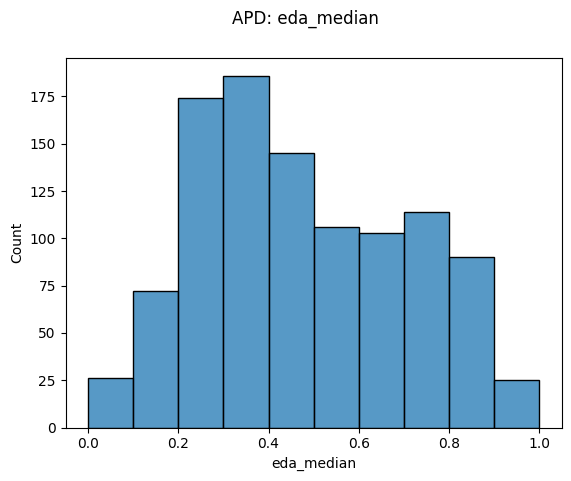

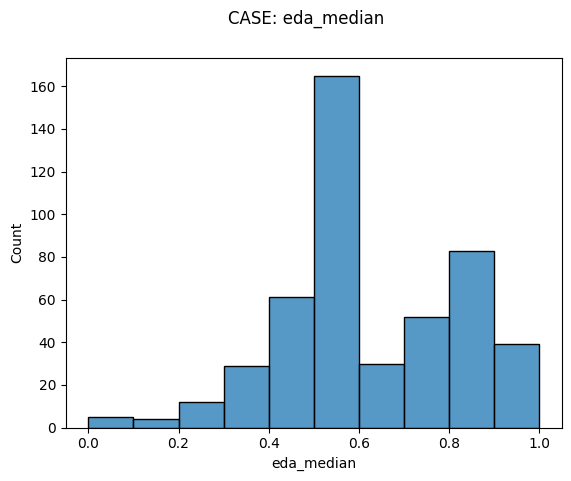

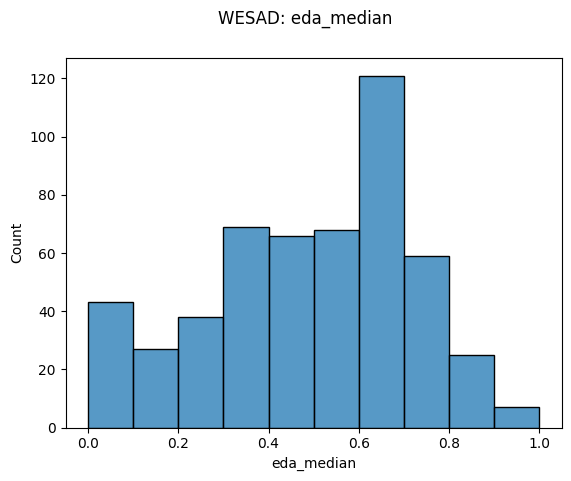

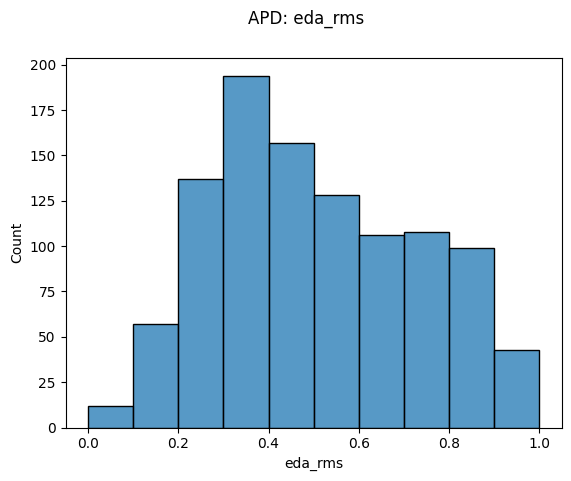

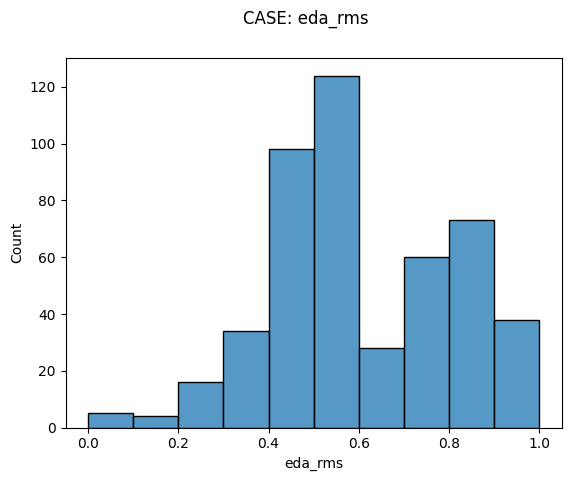

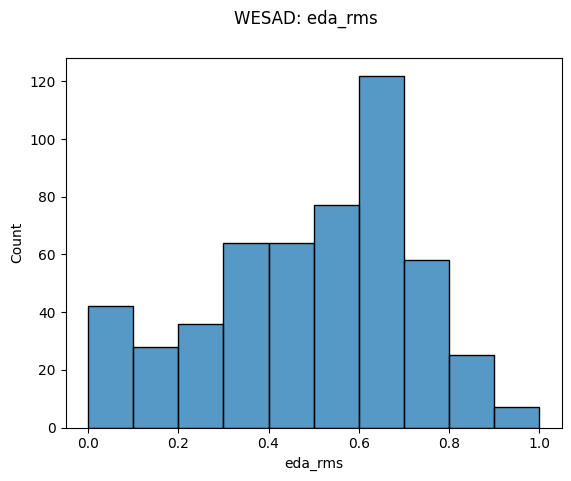

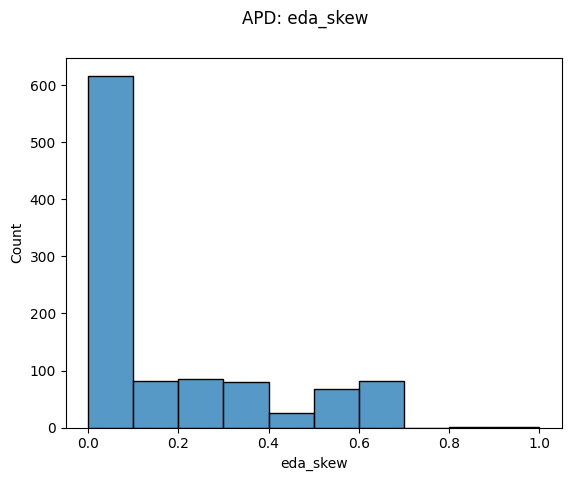

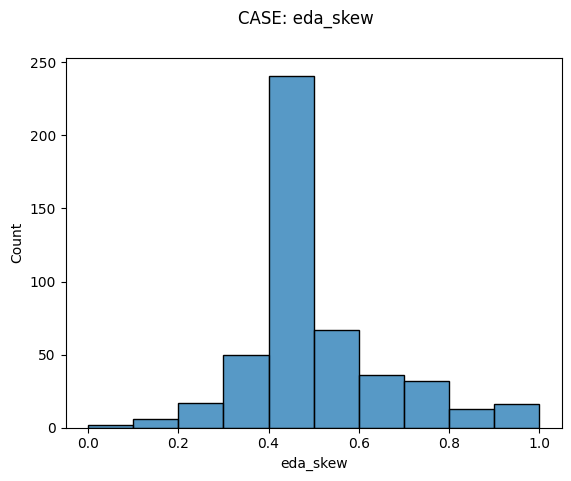

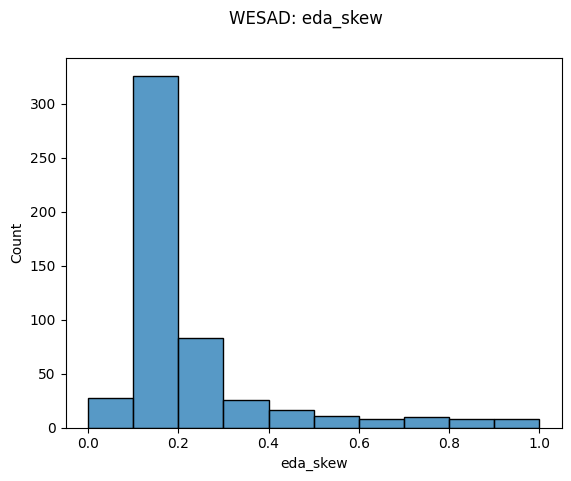

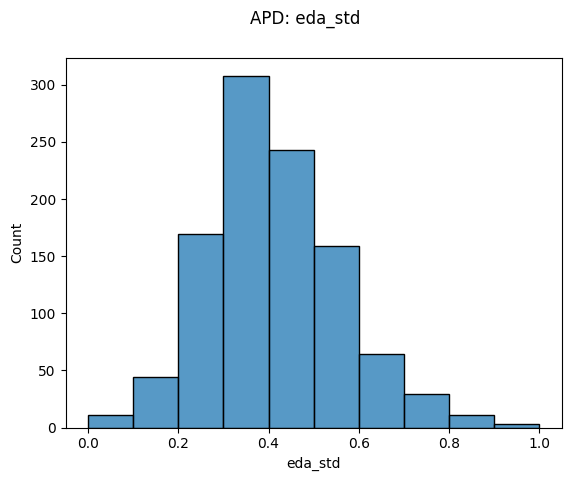

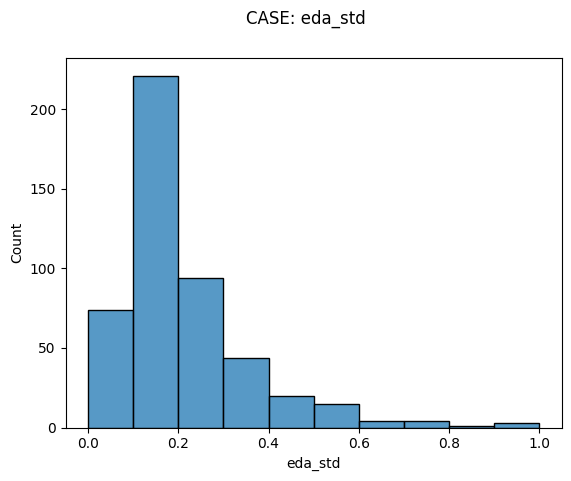

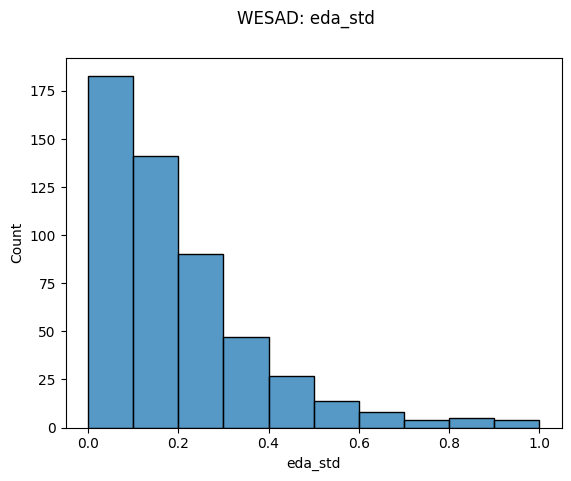

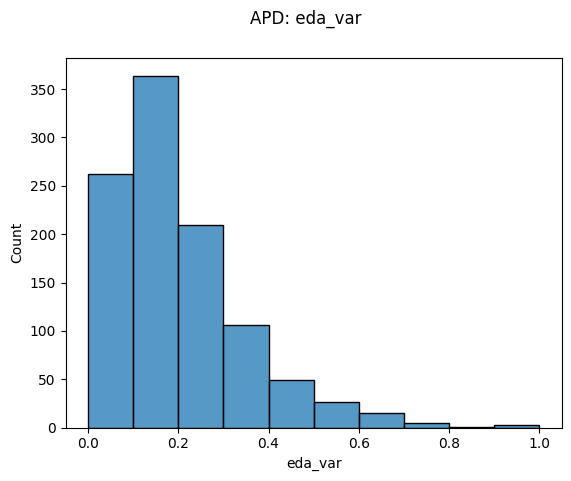

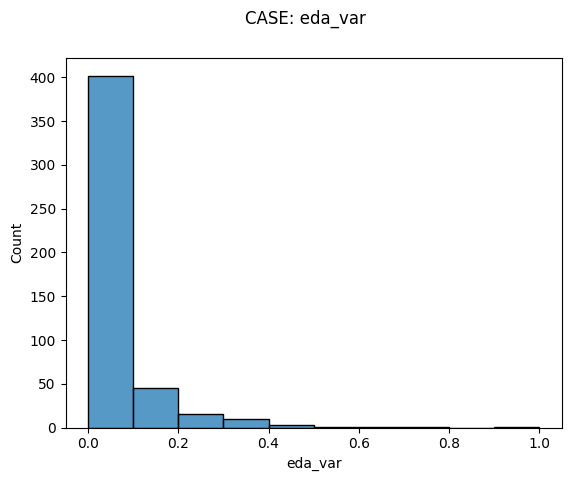

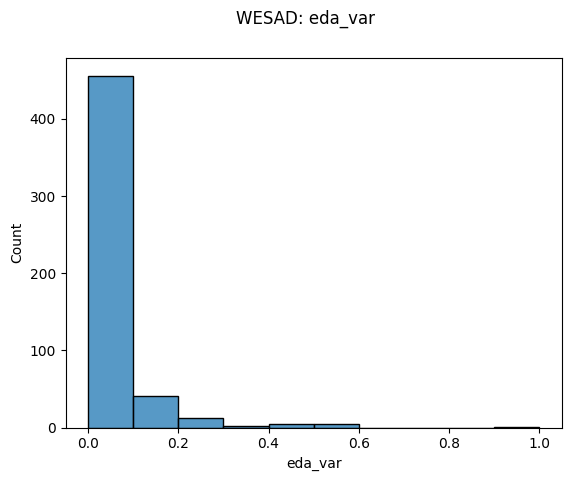

In [30]:
# HISTOGRAMS
importlib.reload(dt)
importlib.reload(train)
importlib.reload(preprocessing)
importlib.reload(dr_a)
importlib.reload(dr_c)
importlib.reload(dr_w)

import matplotlib
import seaborn as sns
import pandas as pd


metrics = [
    train.Metrics.BPM, 
    train.Metrics.RMSSD, 
    train.Metrics.HF_RR, 
    train.Metrics.LF_RR, 
    train.Metrics.SDNN, 
    train.Metrics.MEAN_SCL, 
    train.Metrics.SCR_RATE,
    train.Metrics.ECG_IQR, 
    train.Metrics.ECG_KURTOSIS, 
    train.Metrics.ECG_MEAN,
    train.Metrics.ECG_MEDIAN, 
    train.Metrics.ECG_RMS, 
    train.Metrics.ECG_SKEW, 
    train.Metrics.ECG_STD, 
    train.Metrics.ECG_VAR,
    train.Metrics.EDA_IQR,
    train.Metrics.EDA_KURTOSIS, 
    train.Metrics.EDA_MEAN, 
    train.Metrics.EDA_MEDIAN, 
    train.Metrics.EDA_RMS, 
    train.Metrics.EDA_SKEW, 
    train.Metrics.EDA_STD, 
    train.Metrics.EDA_VAR
]

x_a, y_a = train.Train_APD.get_apd_data_ranking(metrics, model_phases_apd, verbose=False, anxiety_label_type=anxiety_label_type, threshold=threshold, normalize=True)
x_c, y_c = train.Train_CASE.get_case_data(metrics, verbose=False, label_type=case_label_type, threshold=threshold, normalize=True)
x_w, y_w = train.Train_WESAD.get_wesad_data(metrics, model_phases_wesad, verbose=False, label_type=wesad_label_type, threshold=threshold, normalize=True)

data = [x_a, x_c, x_w]

matplotlib.rcParams.update({'font.size': 10})
matplotlib.rcParams.update({'lines.markersize': 3})
# fig, axs = plt.subplots(len(metrics), 1, figsize=(12, 40))

for i, metric in enumerate(metrics):
    data_dict = {
        "APD": data[0].loc[:, metric],
        "CASE": data[1].loc[:, metric],
        "WESAD": data[2].loc[:, metric]
    }
    # df = pd.DataFrame(data_dict)
    for key in data_dict.keys():
        fig = plt.figure()
        fig.suptitle(f"{key}: {metric}")
        box = sns.histplot(data_dict[key], binwidth=0.1)
        # box = sns.histplot(data_dict[key])
        plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


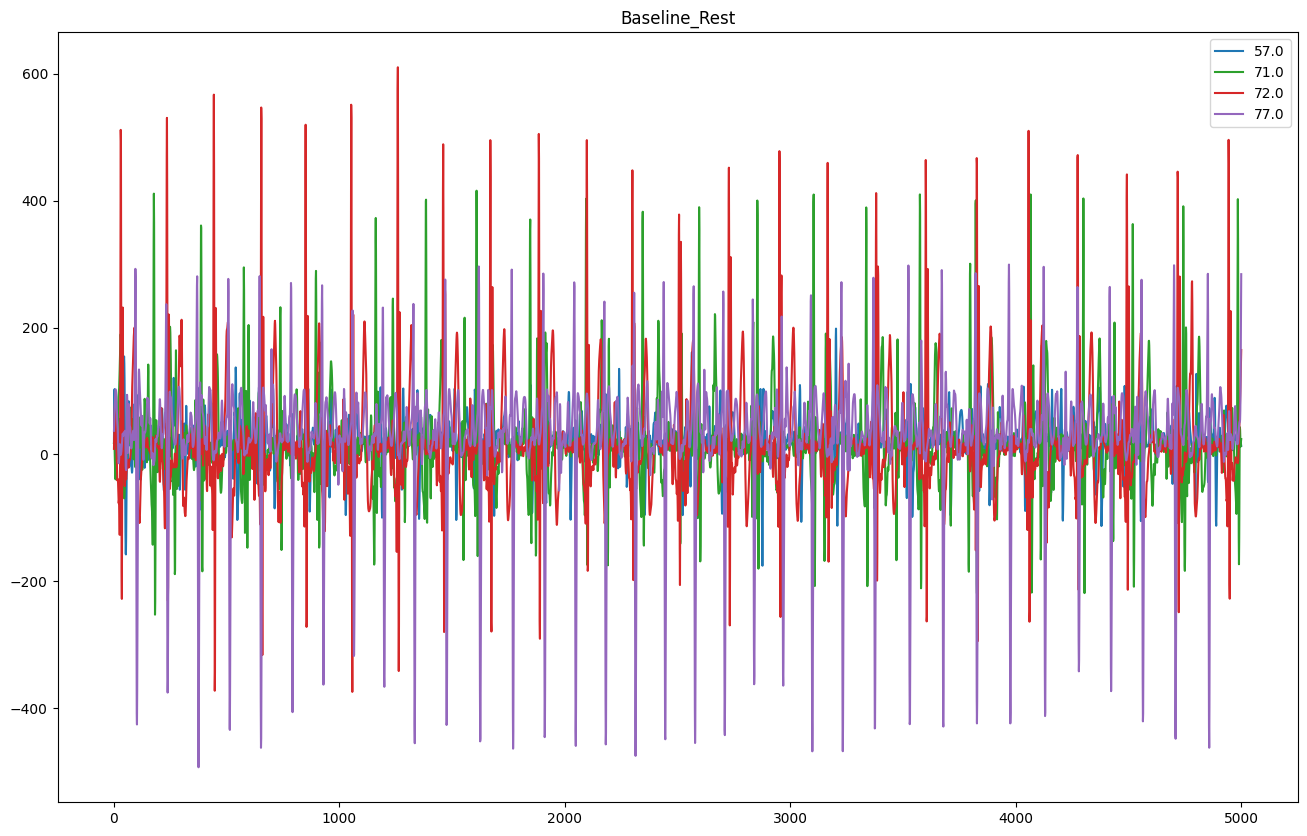

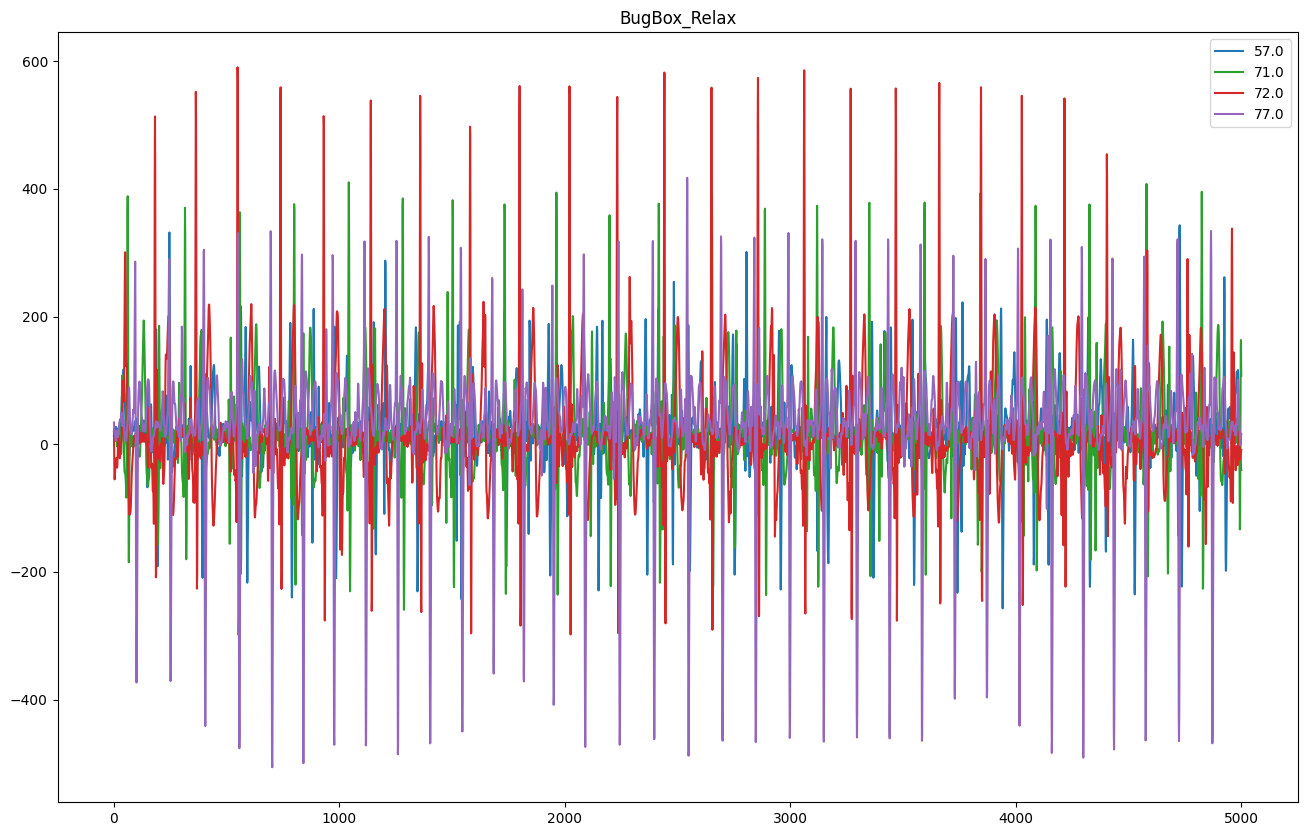

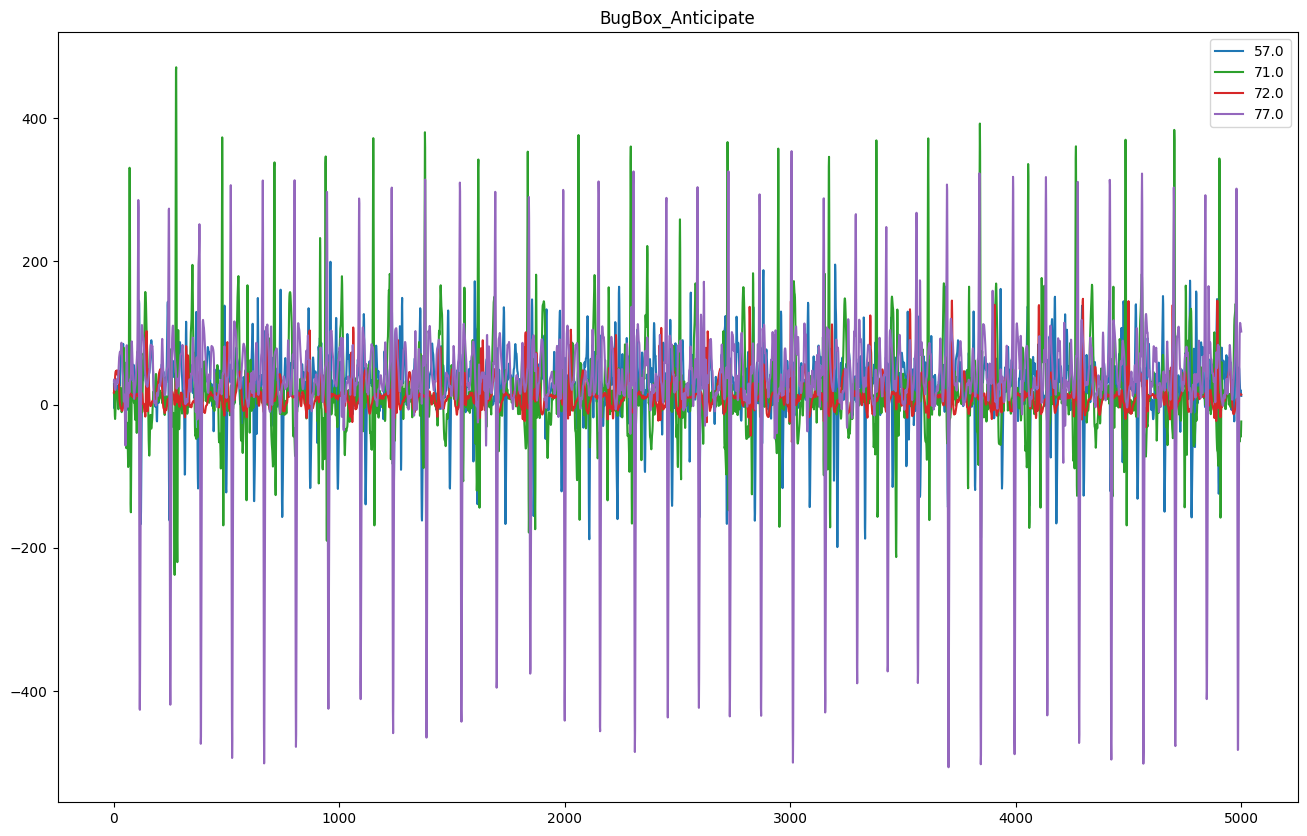

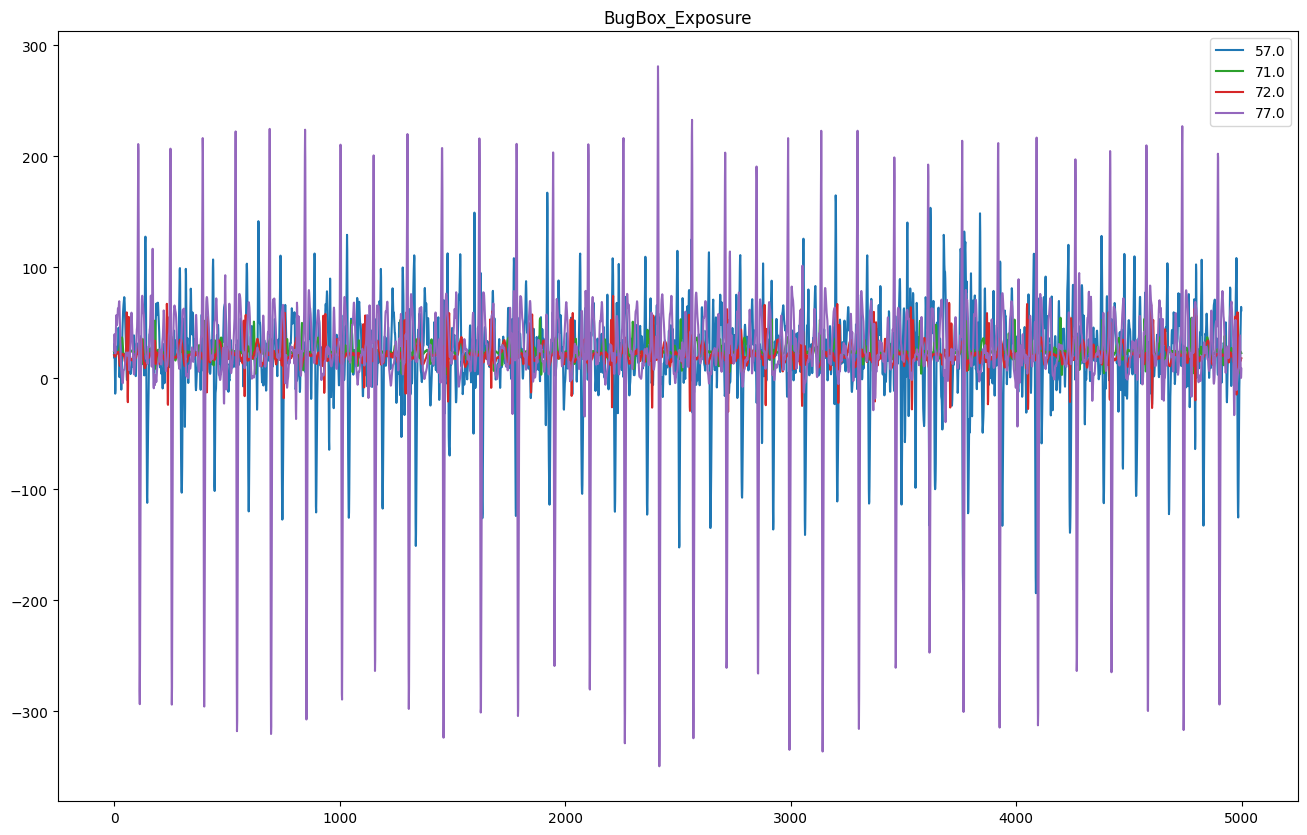

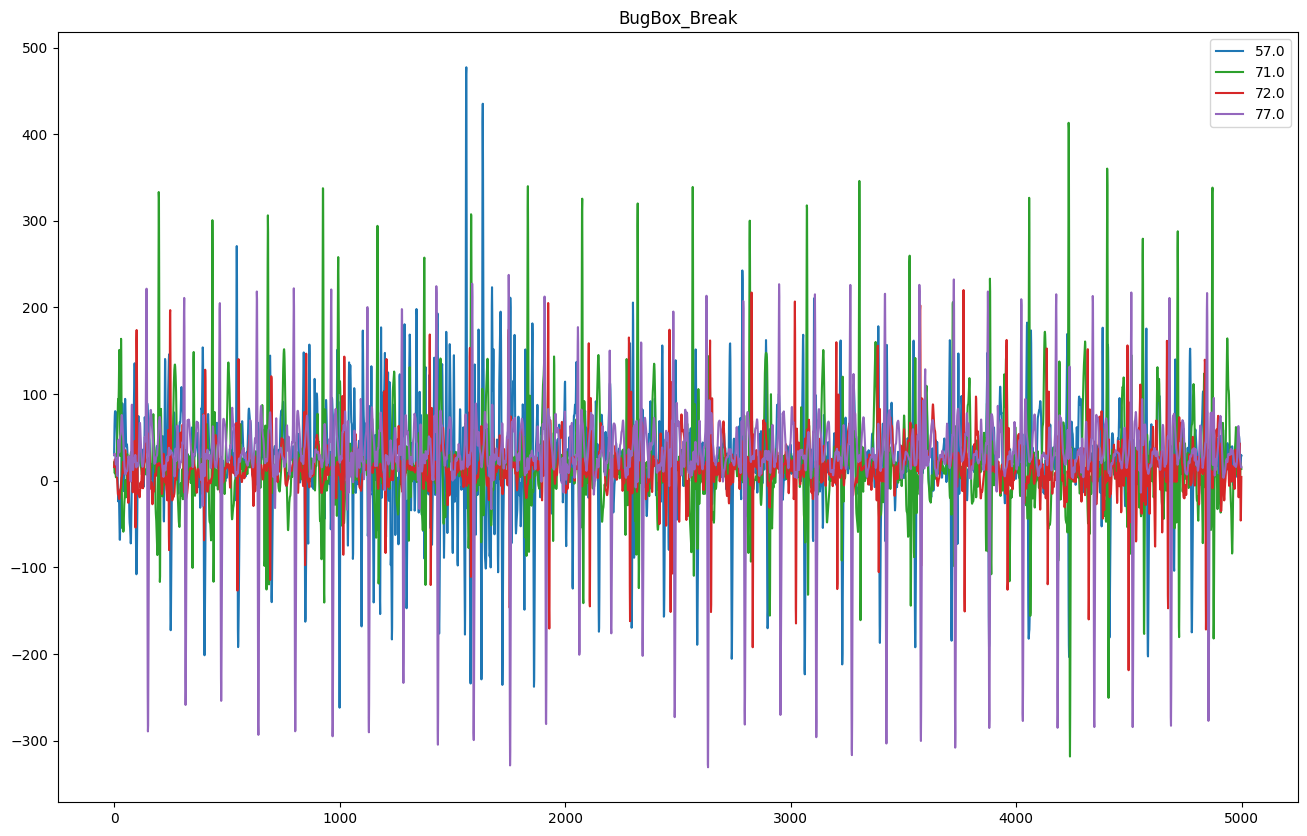

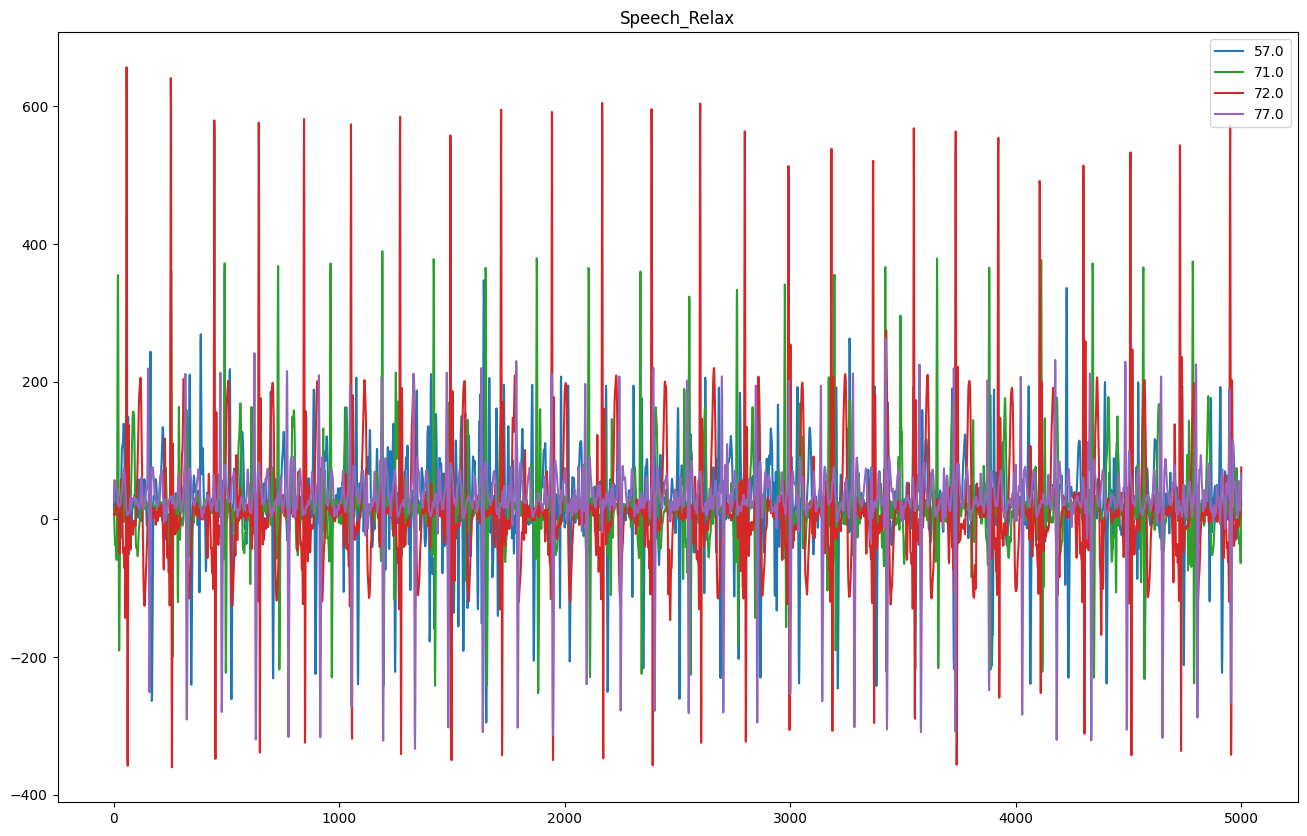

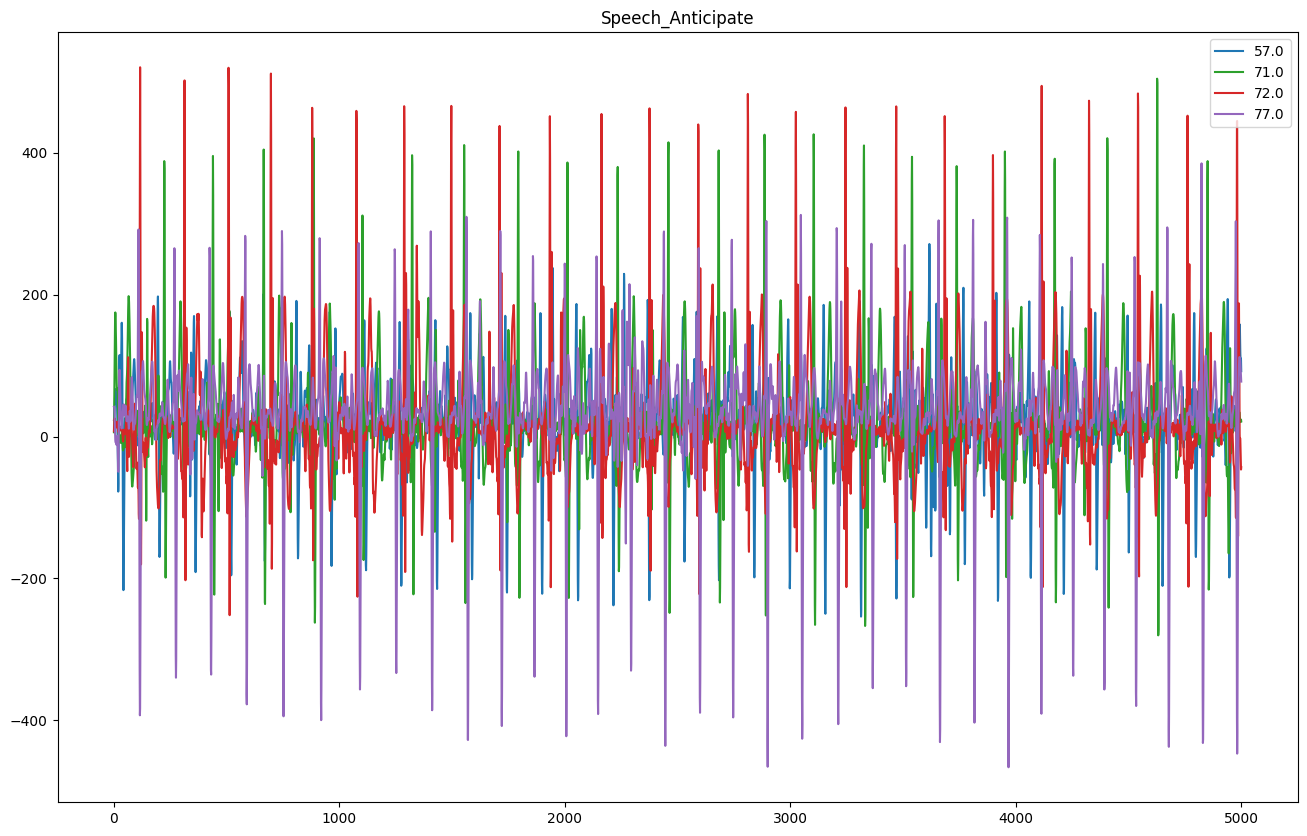

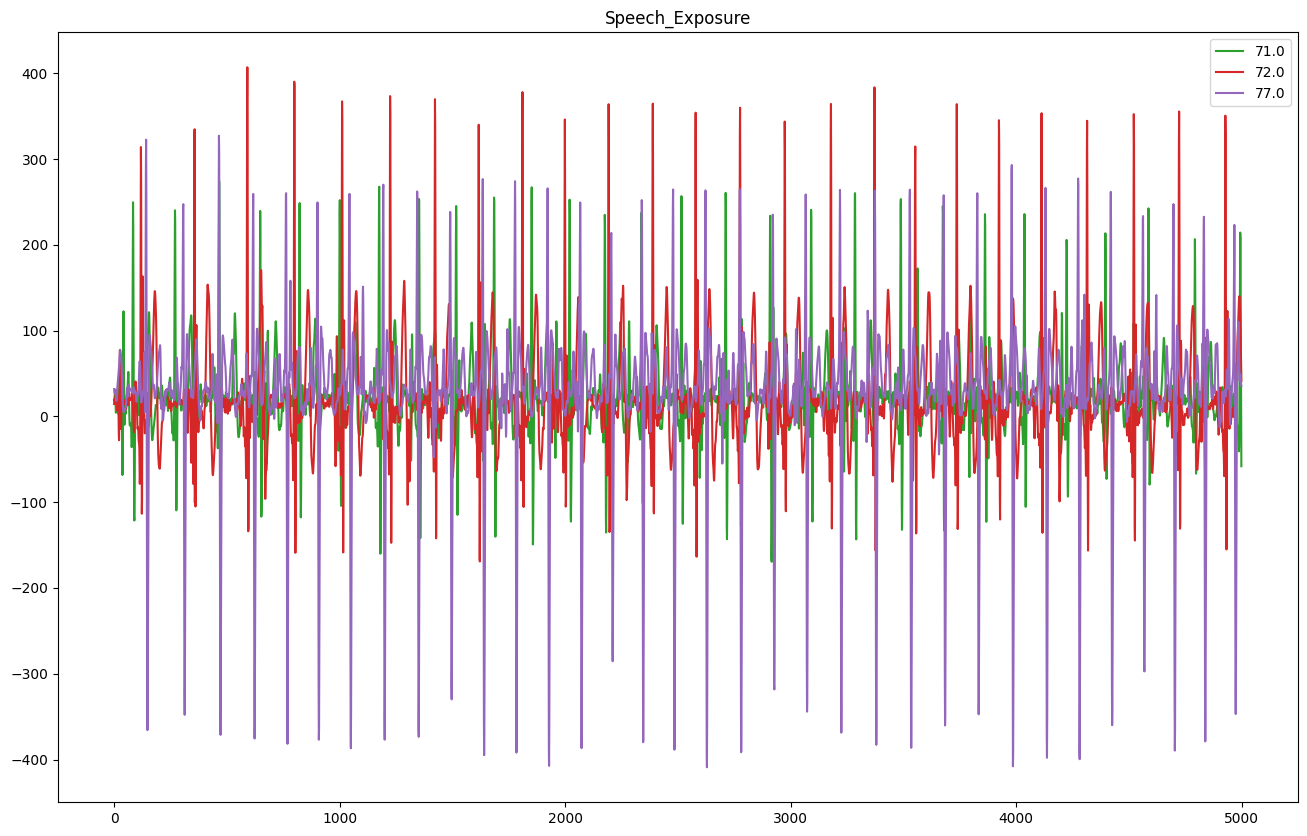

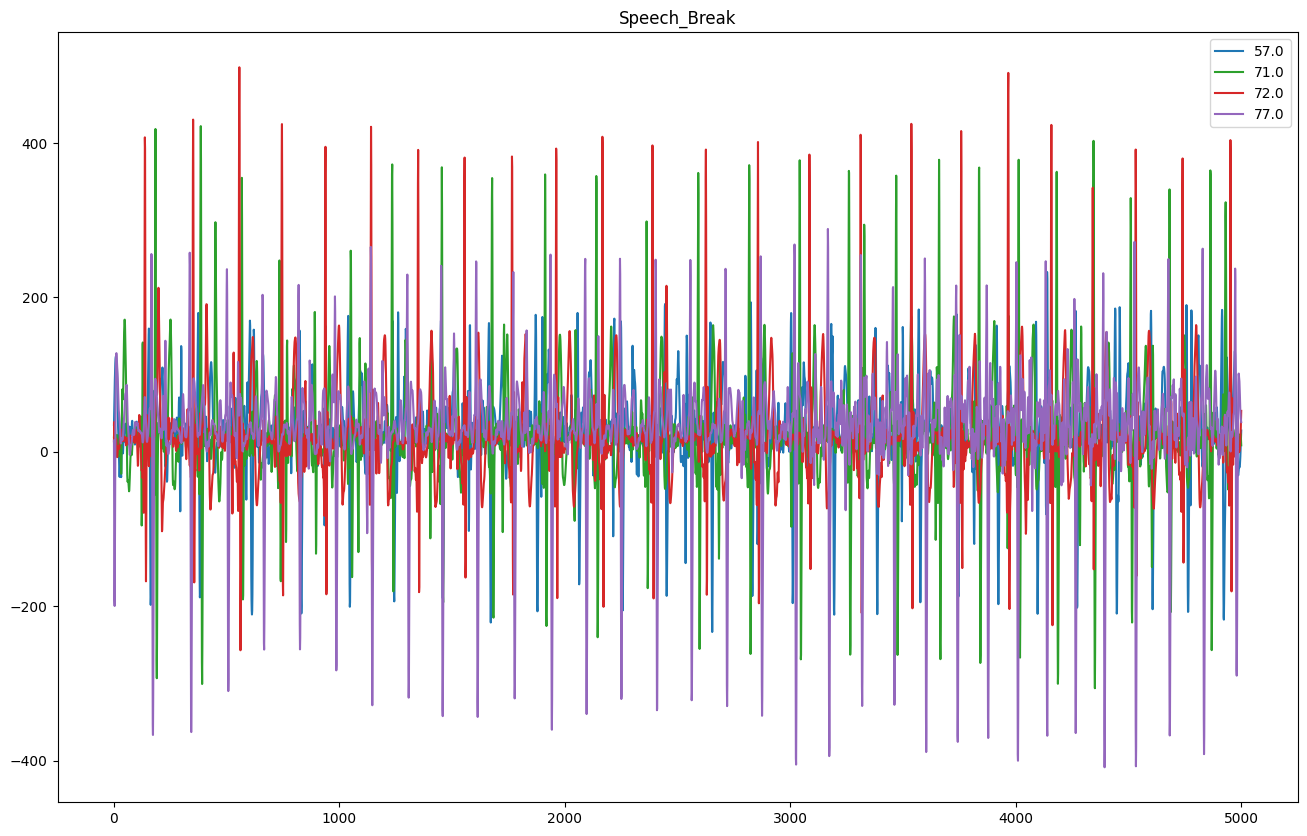

In [31]:
# APD
importlib.reload(dt)
importlib.reload(train)
importlib.reload(preprocessing)
importlib.reload(dr_a)
importlib.reload(dr_c)
importlib.reload(dr_w)

import biosppy
import matplotlib
import seaborn as sns
import pandas as pd

from heartpy.preprocessing import scale_data

colors = [
    "tab:blue", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan"
]


convert_sr = False
is_clean_ecg = False
tasks = [dr_a.Tasks.BASELINE, dr_a.Tasks.BUGS, dr_a.Tasks.SPEAKING]
data_type = dr_a.DataTypes.ECG
fs = 250.0

for task in tasks:
    if task == dr_a.Tasks.BASELINE:
        phases = [dr_a.Phases.BASE_REST]
    elif task == dr_a.Tasks.BUGS:
        phases = [dr_a.Phases.BUG_RELAX, dr_a.Phases.BUG_ANTICIPATE, dr_a.Phases.BUG_EXPOSURE, dr_a.Phases.BUG_BREAK]
    else:
        phases = [dr_a.Phases.SPEECH_RELAX, dr_a.Phases.SPEECH_ANTICIPATE, dr_a.Phases.SPEECH_EXPOSURE, dr_a.Phases.SPEECH_BREAK]
    for phase in phases:
        plt.figure(figsize=(16, 10))
        plt.title(phase)
        ha_ecg, la_ecg = preprocessing.load_data(task, data_type, phase, convert_sr, is_clean_ecg)
        # for i in range(len(ha_ecg)):
        for i in range(9, 13):
            s = ha_ecg[i].iloc[0, 0]
            signal = ha_ecg[i].iloc[:, -1].reset_index(drop=True)
            signal = scale_data(signal)
        
            if signal.size > 1:
                signal = biosppy.signals.ecg.ecg(signal=signal, sampling_rate=fs, show=False)
                signal = signal["filtered"]
                # filtered.insert(0, int(s))
                # data.append(filtered)
                color_idx = i % len(colors)
                try:
                    plt.plot(signal[0:5000], color=colors[color_idx], label=s)
                except Exception:
                    pass
            plt.legend()

        # for s in list(df_dict.keys()):
        #     df = df_dict[s]
        #     signal = df.iloc[:, -1]

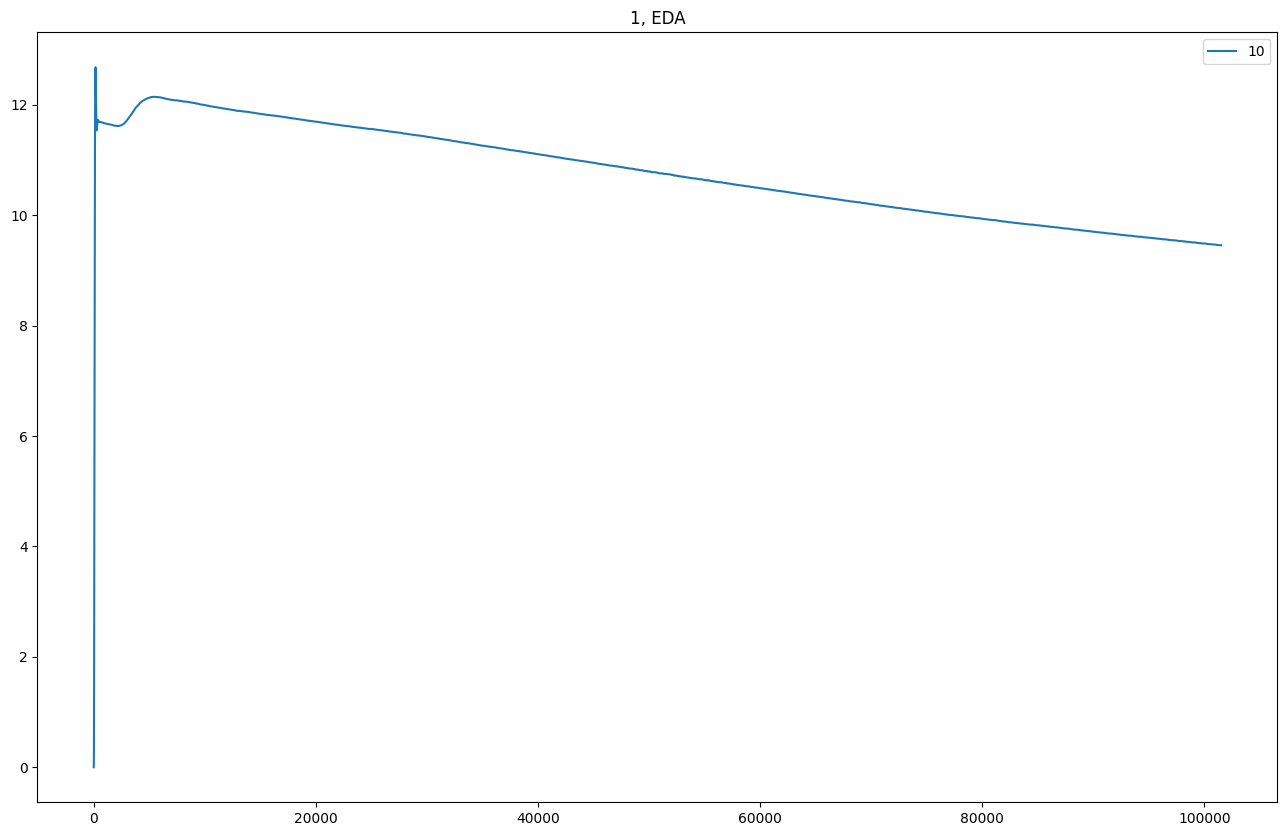

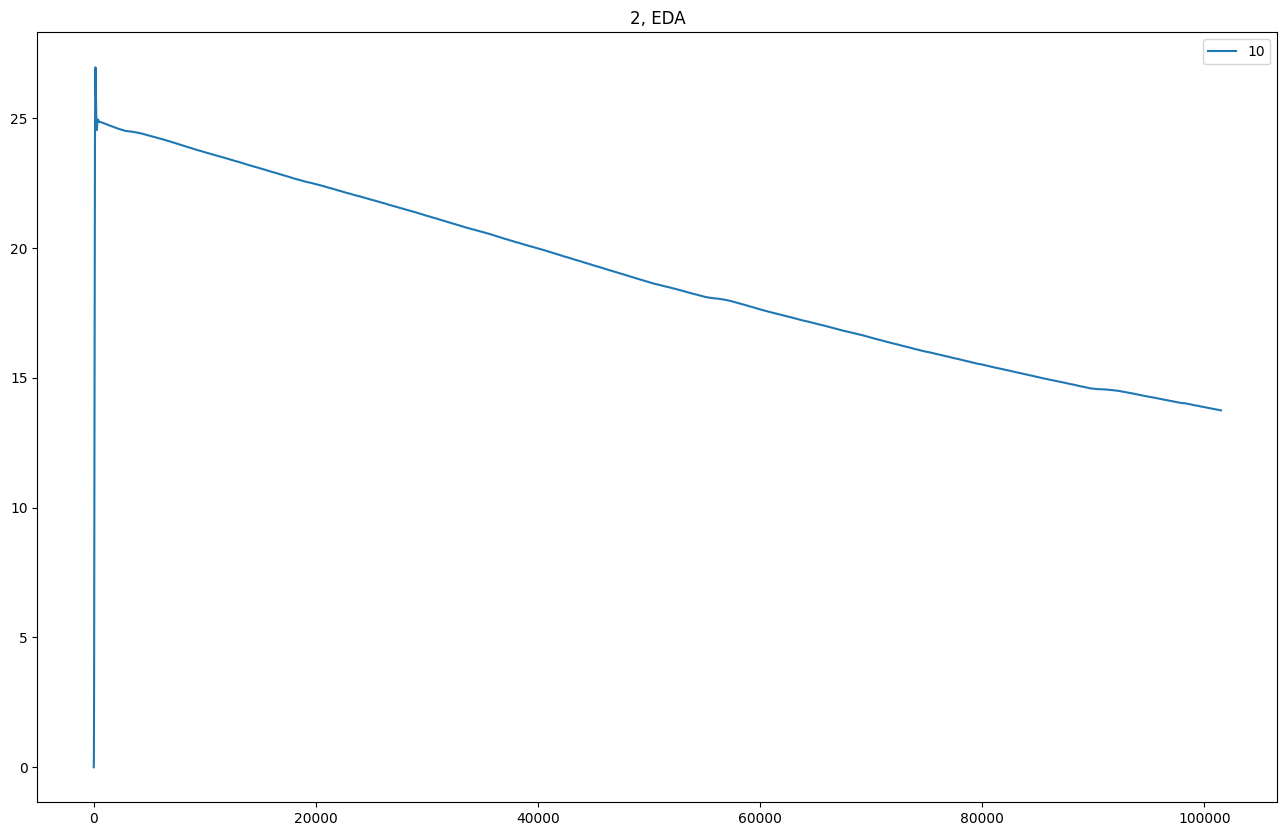

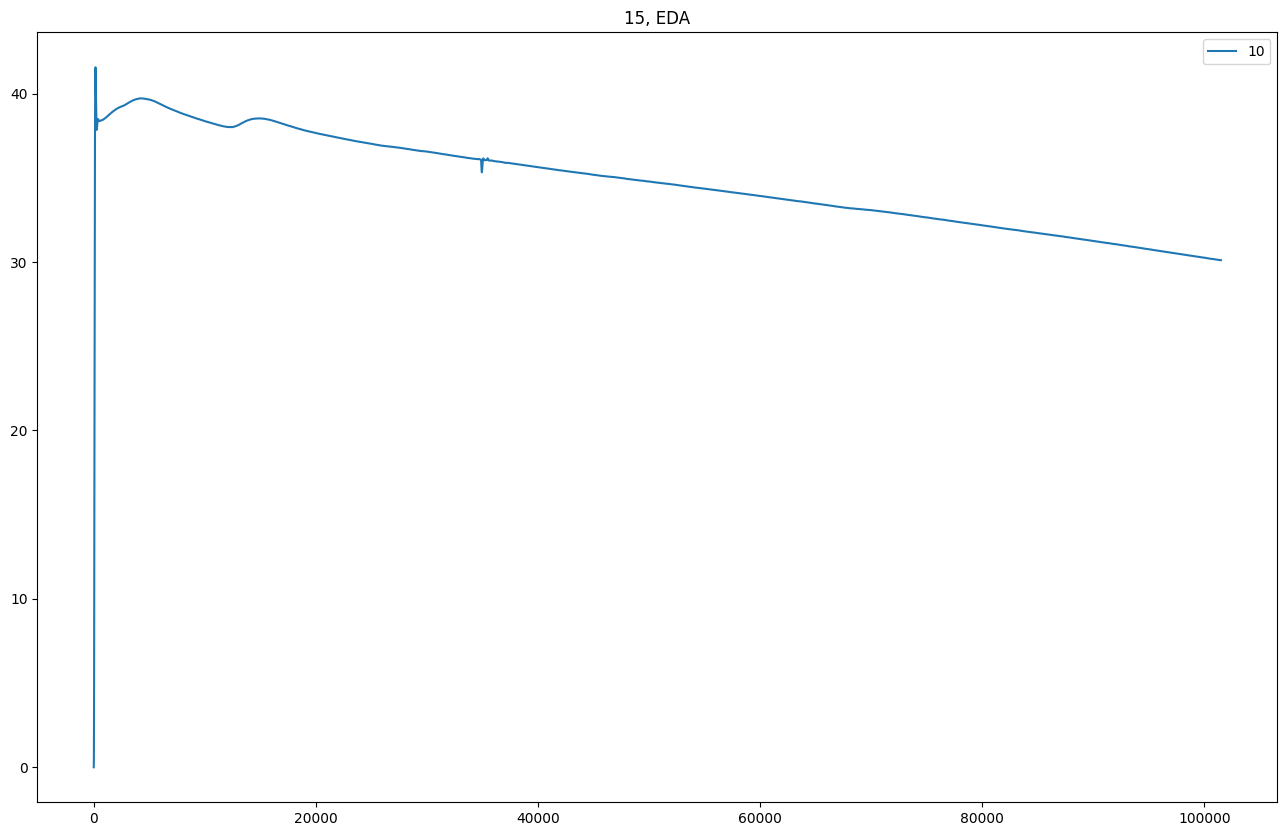

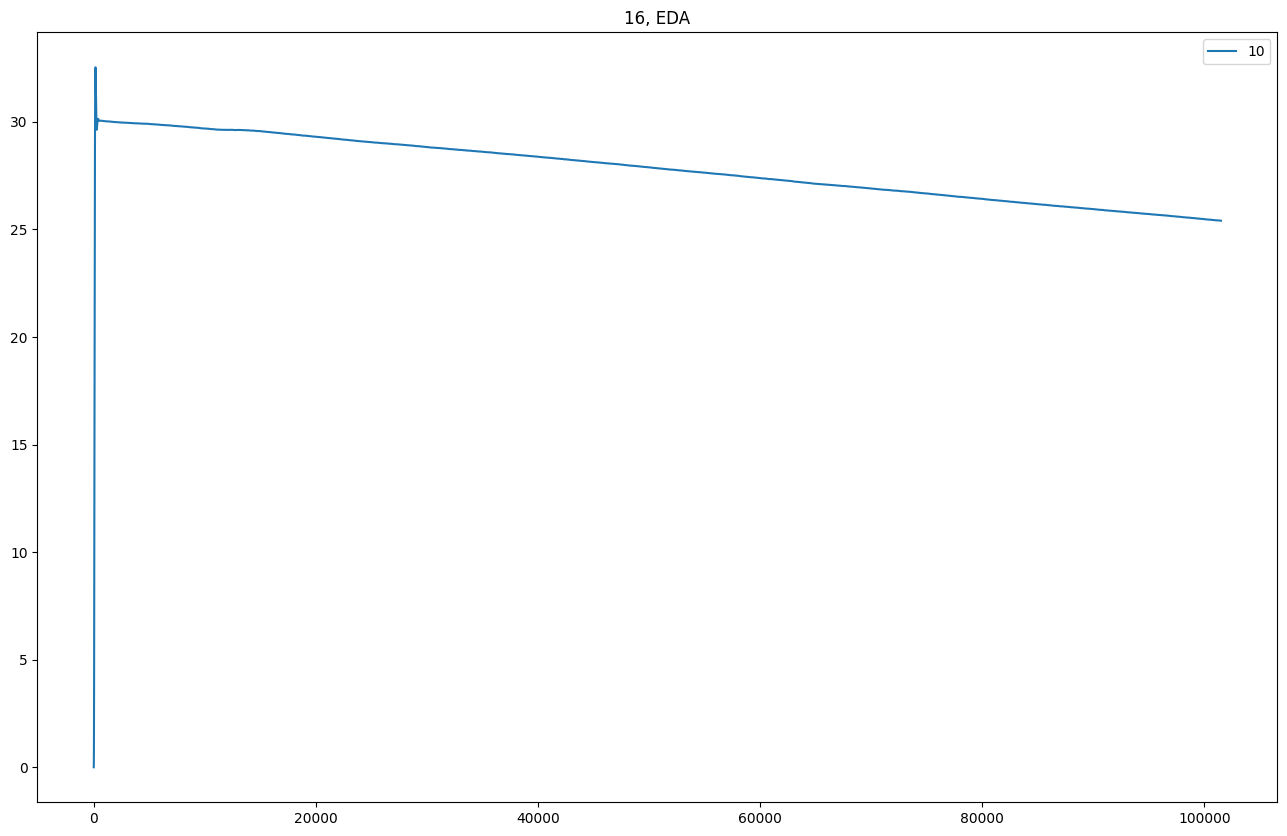

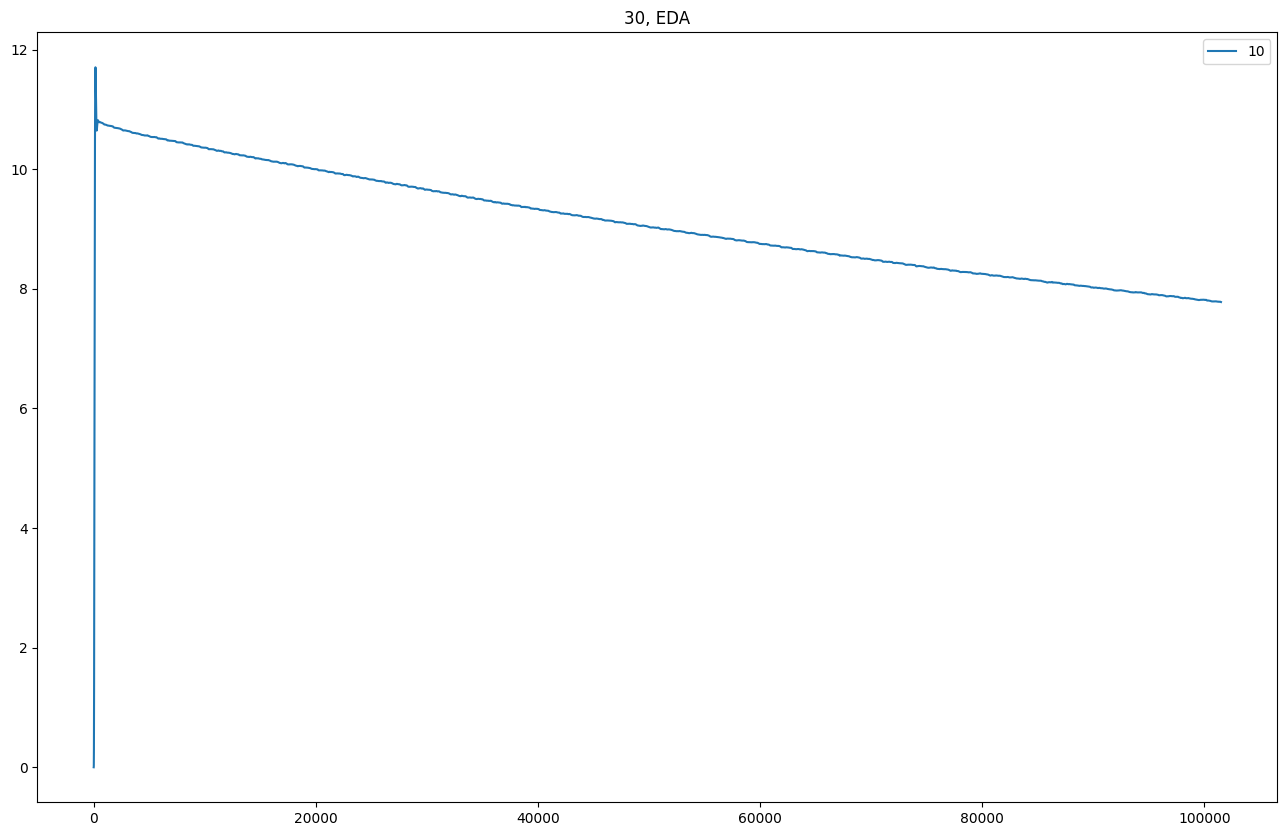

In [32]:
# CASE
importlib.reload(dt)
importlib.reload(train)
importlib.reload(preprocessing)
importlib.reload(dr_a)
importlib.reload(dr_c)
importlib.reload(dr_w)

import biosppy
import matplotlib
import seaborn as sns
import pandas as pd
from scipy.signal import butter, lfilter

colors = [
    "tab:blue", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan"
]

# phases = dr_c.CLIPS
phases = [10]
# subjects = dr_c.SUBJECTS
subjects = [1, 2, 15, 16, 30]
fs = 1000.0

# for phase in phases:
#     # data = []
#     df_dict = {s: dr_c.read_ecg(s, phase) for s in subjects}
#     plt.figure(figsize=(16, 10))
#     plt.title(f"{phase}, ECG")
#     for i, s in enumerate(df_dict.keys()):
#         df = df_dict[s]
#         signal = df.iloc[:, -1].reset_index(drop=True)
        
#         # signal = biosppy.signals.ecg.ecg(signal=signal, sampling_rate=fs, show=False)
#         # signal = signal["filtered"]
#         # filtered.insert(0, int(s))
#         # data.append(filtered)
#         plt.plot(signal[0:5000], color=colors[i], label=s)
#     plt.legend()

order = 3
cutoff = 5
b, a = butter(order, cutoff, fs=fs, btype='low', analog=False)
# for phase in phases:
#     # data = []
#     df_dict = {s: dr_c.read_gsr(s, phase) for s in subjects}
#     plt.figure(figsize=(16, 10))
#     plt.title(f"{phase}, EDA")
#     for i, s in enumerate(df_dict.keys()):
#         df = df_dict[s]
#         signal = df.iloc[:, -1]
#         filtered = lfilter(b, a, signal)
#         # signal = biosppy.signals.eda.eda(signal=signal, sampling_rate=fs, show=False)
#         # filtered = signal["filtered"]
#         # filtered.insert(0, int(s))
#         data.append(filtered)
#         plt.plot(filtered, color=colors[i], label=s)
#         plt.legend()

for s in subjects:
    # data = []
    dfs = [dr_c.read_gsr(s, phase) for phase in phases]
    plt.figure(figsize=(16, 10))
    plt.title(f"{s}, EDA")
    for i, phase in enumerate(phases):
        df = dfs[i]
        signal = df.iloc[:, -1]
        filtered = lfilter(b, a, signal)
        # signal = biosppy.signals.eda.eda(signal=signal, sampling_rate=fs, show=False)
        # filtered = signal["filtered"]
        # filtered.insert(0, int(s))
        data.append(filtered)
        plt.plot(filtered, color=colors[i], label=phase)
        plt.legend()